In [201]:
import numpy as np
import pandas as pd
import random
import copy
import random
import math
import glob
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.optimize import minimize
from scipy.optimize import linear_sum_assignment
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.datasets import fetch_openml
from sklearn.datasets import fetch_olivetti_faces
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

## LDMGI

#### Step 1: For each data point $x_i$, construct its local clique $N_k(x_i), i = 1, . . . , n$;

In [2]:
# X: N-samples x M-features training data
# k: number of neighbors
def LocalCliques(X : np.array, k : int) -> np.array:  
    knn = NearestNeighbors(n_neighbors=k).fit(X)
    distances, indices = knn.kneighbors(X)
    return indices

#### Step 2: Compute $Li = H_k(\bar X_i^T \bar X_i + λI)^{−1} H_k$, where $\bar X_i = X_i H_k$ and $ H_k = I_k - 1_d 1_d^T / d$

In [3]:
# Xi: M-features x k-neighbors local clique sample of xi
# alpha: regularization parameter
# Li: k-neighbors x k-neighbors laplacian matrix for local discriminative model
def LocalLaplacianMatrix(Xi: np.array, alpha: np.float64 = 1.0) -> np.array:
    k = Xi.shape[1]
    I = np.identity(k)
    Hk = I - np.ones(k) / k
    Xbar = np.matmul(Xi, Hk)
    try:  
        inverse = np.linalg.inv(np.matmul(Xbar.T, Xbar) + alpha * I)
    except np.linalg.LinAlgError:
        inverse = np.linalg.pinv(np.matmul(Xbar.T, Xbar) + alpha * I)
    Li = Hk @ inverse @ Hk
    return Li

# Fi: index set of Nk(Xi) with length k
# n: number samples in training data
# Si: N-samples x k-neighbors selection matrix
def SelectionMatrix(Fi : np.array, n: int) -> np.array:
    k = len(Fi)
    Si = np.zeros((n, k))
    for q, p in enumerate(Fi):
        Si[p, q] = 1
    return Si

#### Step 3: Compute $L = \sum_{i=1}^n Si L_i S_i^T$, where $(S_i)pq = 1$ if $p = F_i{q}$ else 0 

In [4]:
# X: N-samples x M-features training data
# F: N-samples x k-neighbors index set
def LaplacianMatrix(X : np.array, F : np.array,alpha) -> np.array:
    n = X.shape[0]  # number of samples
    L = np.zeros((n, n))
    for Fi in F:
        Xi = X[Fi].T
        Li = LocalLaplacianMatrix(Xi,alpha)
        Si = SelectionMatrix(Fi, n)
        L += Si @ Li @ Si.T
    return L

#### Step 4: Eigenvalue decomposition for the Laplacian Matrix L: $ L u_i=\lambda_i u_i $ the optimal $G^* = [u_1, u_2, ...u_c]$, i.e. eigenvectors excluding the trivial solution $u_0 = \vec{1_n}$

In [5]:
# L: N-samples x N-samples Laplacian Matrix
# c: number of clusters
def OptimalScaledAssignmentMatrix(L : np.array, c: int) -> np.array:
    eigenValues, eigenVectors = np.linalg.eig(L)
    idx = eigenValues.argsort()  # sort ascendingly
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return eigenVectors[:, 1:c+1]

#### Step 5: Compute $Y^* = Diag(G^*G^{*T})^{-1/2}G^*$ and solve the optimization problem $argmin ||Y - Y^*R||^2 s.t. Y\vec{1_c} = \vec{1_n}, R^T R = I$ where $Y \in B^{n*c}$ is the binary cluster matrix and $R \in R^{c*c}$ is the rotation matrix with spectral rotation 

In [6]:
# G: n-samples x c-clusters OptimalScaledAssignmentMatrix
# Y0: n-cluster x c-cluster
from scipy.linalg import svd
def InitializeY(G : np.array) -> np.array:
    return np.diag(np.diag(G @ G.T) ** (-1/2)) @ G

# Y0: n-cluster x c-cluster
# R: c-cluster x c-cluster Rotation Matrix
def InitializeR(Y0 : np.array) -> np.array:
    R = []
    n, c = Y0.shape
    i = random.randint(0, n-1) 
    R.append(Y0[i].reshape(-1, 1))
    
    norm = np.zeros((n, 1))
    for k in range(c-1):
        norm += np.abs(Y0 @ R[k])
        i = np.argmin(norm)
        R.append(Y0[i].reshape(-1, 1))
    R = np.concatenate(R, axis=1)
    return R

# Y0: n-samples x c-clusters
# R: c-cluster x c-cluster
# Y: c-cluster x c-cluster binary matrix
def OptimalY(Y0 : np.array, R : np.array) -> np.array: 
    n, c = Y0.shape
    Y = np.zeros((n, c))
    Y1 = Y0 @ R
    for i in range(n):
        j = np.argmax(Y1[i])
        Y[i, j] = 1
    return Y

def OptimalR(Y: np.array, Y0: np.array) -> np.array:
    matrix = Y.T @ Y0
    try:
        U, w, V = np.linalg.svd(matrix) 
    except:
        U, w, V = svd(matrix, lapack_driver='gesvd')

    R = V.T @ U.T
    
    omega = np.diag(w)
    bar = np.trace(omega)
    return R, bar

def OptimizeYR(G, precision, max_loop=100):
    Y0 = InitializeY(G)
    R = InitializeR(Y0)
    bar0 = 0
    i = 0  # count loops
    
    while True:
        Y = OptimalY(Y0, R)
        R, bar = OptimalR(Y, Y0)
        if abs(bar - bar0) < precision:
            break
        bar0 = bar
        i += 1
        if i > max_loop:
            break
    return Y

### Running Process

In [7]:
# global inputs
def compute_acc(y_true, y_pred):
    
    confusion_matrix = np.zeros((n_clusters, n_clusters), dtype=np.int64)
    for i in range(n_clusters):
        mask = y_pred == i
        hist, _ = np.histogram(y_true[mask], bins=np.arange(n_clusters + 1))
        best_match = np.argmax(hist)
        confusion_matrix[i] = hist
    row_ind, col_ind = linear_sum_assignment(-confusion_matrix)
    acc = float(confusion_matrix[row_ind, col_ind].sum()) / float(n_samples)
    
    return acc

In [8]:
# LDMGI algorithm

def LDMGI(X, k, c, precision = 0.1, alpha: np.float64 = 1.0):
    
    F = LocalCliques(X, k)  
    L = LaplacianMatrix(X, F,alpha) 
    G = OptimalScaledAssignmentMatrix(L, c)
    Y = OptimizeYR(G, precision)  
    
    return Y

In [9]:
def diskmeans(X, n_clusters, gamma=0.01):
    
    # Calculate the distance between samples
    pairwise_distances = np.linalg.norm(X[:, None] - X, axis=-1)

    # Calculate the similarity matrix based on the distance
    similarity_matrix = np.exp(-gamma * pairwise_distances)

    # Clustering using the K-means algorithm
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(similarity_matrix)

    # Return to Clustering Label
    return kmeans.labels_

In [202]:
def ncut(images, labels, sigma=0.01):
    
    # Compute the similarity matrix
    n_samples = images.shape[0]
    W = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            diff = np.linalg.norm(images[i] - images[j])
            W[i, j] = np.exp(-np.sum(diff ** 2) / (2 * sigma ** 2))
            W[j, i] = W[i, j]
    
    # Calculation degree matrix
    D = np.diag(np.sum(W, axis=1))
    
    # Compute the Laplace matrix
    L = D - W
    
    # Compute the normalized Laplace matrix
    D_sqrt_inv = np.sqrt(np.linalg.inv(D))
    L_normalized = np.dot(np.dot(D_sqrt_inv, L), D_sqrt_inv)
    
    # Eigenvalue decomposition of the normalized Laplace matrix
    eigvals, eigvecs = np.linalg.eig(L_normalized)
    sorted_indices = np.argsort(eigvals)
    
    # Select the eigenvector corresponding to the first k+1 smallest eigenvalues
    k = len(np.unique(labels))  

    sorted_indices = np.argsort(eigvals)[:k+1]
    eigvecs_selected = eigvecs[:, sorted_indices]
    eigvecs_selected = np.real(eigvecs_selected)

    # Clustering feature vectors using spectral clustering algorithm
    spectral = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', n_jobs=-1)
    spectral.fit(eigvecs_selected)
    predicted_labels = spectral.labels_
    
    return predicted_labels

In [11]:
def LLC_G(images, labels, n_clusters, sigma=0.01, K=5):
    
    # Calculate the distance matrix
    neigh = NearestNeighbors(n_neighbors=K+1)
    neigh.fit(images.reshape((n_samples, -1)))
    distances, indices = neigh.kneighbors(images.reshape((n_samples, -1)))

    # Constructing the weighting matrix
    W = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        diff = images.reshape((n_samples, -1))[i] - images.reshape((n_samples, -1))[indices[i][1:]]
        C = np.dot(diff, diff.T)
        C = C / (np.trace(C) + 1e-5)
        w = np.linalg.solve(C + sigma * np.eye(K), np.ones((K, 1)))
        w = w / np.sum(w)
        W[i, indices[i][1:]] = w.ravel()

    # Constructing the Laplace matrix
    D = np.diag(np.sum(W, axis=1))
    L = D - W

    # spectral clustering
    eigvals, eigvecs = np.linalg.eig(L)
    indices = np.argsort(eigvals)[:n_clusters]
    eigvecs = eigvecs[:, indices]
    eigvecs = np.real(eigvecs)

    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(eigvecs)
    LLC_cluster_labels = kmeans.labels_

    return LLC_cluster_labels

In [39]:
def LLC_L(images, labels, n_clusters, K=5):
    
    # Calculate the distance matrix
    neigh = NearestNeighbors(n_neighbors=K+1)
    neigh.fit(images.reshape((n_samples, -1)))
    distances, indices = neigh.kneighbors(images.reshape((n_samples, -1)))

    # Constructing the weighting matrix
    W = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        diff = images.reshape((n_samples, -1))[i] - images.reshape((n_samples, -1))[indices[i][1:]]
        w = np.linalg.pinv(np.dot(diff, diff.T)).dot(np.ones((K, 1)))
        w = w / np.sum(w)
        W[i, indices[i][1:]] = w.ravel()

    # Constructing the Laplace matrix
    D = np.diag(np.sum(W, axis=1))
    L = D - W

    # spectral clustering
    eigvals, eigvecs = np.linalg.eig(L)
    indices = np.argsort(eigvals)[:n_clusters]
    eigvecs = eigvecs[:, indices]
    eigvecs = np.real(eigvecs)

    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(eigvecs)
    LLC_cluster_labels = kmeans.labels_

    return LLC_cluster_labels

In [209]:
def run_five_algos():
    
    global images
    global labels
    global n_samples
    global n_features
    global n_clusters
    
    nrounds = [1,2,3,4,5,6,7,8,9,10]
    
    #####################################LDMGI#####################################
    n_random_indice = min(2000,images.shape[0])
    images = images.reshape((images.shape[0], images.shape[1]*images.shape[2]))
    images_raw = copy.deepcopy(images)
    labels_raw = copy.deepcopy(labels)
    k = 5  # number of neighbors 
    c = len(np.unique(labels))   # number of clusters 
    alpha = 1   # default parameter
    precision = 0.1  # precision to stop
    nrounds_LDMGI_accs = [0]
    nrounds_LDMGI_nmis = [0]
    different_nrounds_LDMGI_accs = []
    different_nrounds_LDMGI_nmis = []
    for nround in nrounds:
        images = copy.deepcopy(images_raw)
        labels = copy.deepcopy(labels_raw)
        np.random.seed(nround)
        indices = np.random.choice(len(images), n_random_indice, replace=False)

        # Get the corresponding samples and labels according to the selected indexes
        images = images[indices]
        labels = labels[indices]
        n_samples, n_features = images.shape
        n_clusters = len(np.unique(labels))
        parameters = [10**(-8), 10**(-6), 10**(-4), 10**(-2), 10**(0), 10**(2), 10**(4), 10**(6), 10**(8)]

        LDMGI_accs = []
        LDMGI_nmis = []

        for i in parameters:
            alpha = i

            # LDMGI
            Y = LDMGI(X=images, k=5, c=n_clusters, alpha = alpha)
            y_pred_ldmgi = Y.argmax(axis=1)
            acc = compute_acc(labels, y_pred_ldmgi)
            LDMGI_accs.append(acc)
            nmi = normalized_mutual_info_score(labels, y_pred_ldmgi)
            LDMGI_nmis.append(nmi)
        if max(LDMGI_accs) > max(nrounds_LDMGI_accs):
            nrounds_LDMGI_accs = LDMGI_accs
        if max(LDMGI_nmis) > max(nrounds_LDMGI_nmis):
            nrounds_LDMGI_nmis = LDMGI_nmis
        different_nrounds_LDMGI_accs.append(max(nrounds_LDMGI_accs))
        different_nrounds_LDMGI_nmis.append(max(nrounds_LDMGI_nmis))
    print("LDMGI")
    print("max acc:", max(nrounds_LDMGI_accs))
    print("max nmi:",max(nrounds_LDMGI_nmis))
    print("mean acc:",np.mean(different_nrounds_LDMGI_accs),"±",np.std(different_nrounds_LDMGI_accs))
    print("mean nmi:",np.mean(different_nrounds_LDMGI_nmis),"±",np.std(different_nrounds_LDMGI_nmis))

    #####################################K-Means Clustering#####################################
    nrounds_KMeans_acc = 0
    nrounds_KMeans_nmi = 0
    different_nrounds_KMeans_accs = []
    different_nrounds_KMeans_nmis = []
    for nround in nrounds:
        images = copy.deepcopy(images_raw)
        labels = copy.deepcopy(labels_raw)
        np.random.seed(nround)
        indices = np.random.choice(len(images), n_random_indice, replace=False)

        # Get the corresponding samples and labels according to the selected indexes
        images = images[indices]
        labels = labels[indices]
        n_samples, n_features = images.shape
        n_clusters = len(np.unique(labels))
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(images.reshape((n_samples, -1)))
        cluster_labels = kmeans.labels_
        acc = compute_acc(labels, cluster_labels)
        if acc > nrounds_KMeans_acc:
            nrounds_KMeans_acc = acc
        nmi = normalized_mutual_info_score(labels, cluster_labels)
        if nmi > nrounds_KMeans_nmi:
            nrounds_KMeans_nmi = nmi
        different_nrounds_KMeans_accs.append(nrounds_KMeans_acc)
        different_nrounds_KMeans_nmis.append(nrounds_KMeans_nmi)
    print("KMeans")
    print("max acc:", nrounds_KMeans_acc)
    print("max nmi:", nrounds_KMeans_nmi)
    print("mean acc:",np.mean(different_nrounds_KMeans_accs),"±",np.std(different_nrounds_KMeans_accs))
    print("mean nmi:",np.mean(different_nrounds_KMeans_nmis),"±",np.std(different_nrounds_KMeans_nmis))

    #####################################DisKmeans#####################################
    nrounds_DisKmeans_accs = [0]
    nrounds_DisKmeans_nmis = [0]
    different_nrounds_DisKmeans_accs = []
    different_nrounds_DisKmeans_nmis = []
    for nround in nrounds:
        images = copy.deepcopy(images_raw)
        labels = copy.deepcopy(labels_raw)
        np.random.seed(nround)
        indices = np.random.choice(len(images), n_random_indice, replace=False)

        # Get the corresponding samples and labels according to the selected indexes
        images = images[indices]
        labels = labels[indices]
        n_samples, n_features = images.shape
        n_clusters = len(np.unique(labels))
        parameters = [10**(-8), 10**(-6), 10**(-4), 10**(-2), 10**(0), 10**(2), 10**(4), 10**(6), 10**(8)]

        DisKmeans_accs = []
        DisKmeans_nmis = []
        for i in parameters:

            cluster_labels = diskmeans(images.reshape((n_samples, -1)), n_clusters, gamma=i)
            acc = compute_acc(labels, cluster_labels)
            DisKmeans_accs.append(acc)
            nmi = normalized_mutual_info_score(labels, cluster_labels)
            DisKmeans_nmis.append(nmi)
        if max(DisKmeans_accs) > max(nrounds_DisKmeans_accs):
            nrounds_DisKmeans_accs = DisKmeans_accs
        if max(DisKmeans_nmis) > max(nrounds_DisKmeans_nmis):
            nrounds_DisKmeans_nmis = DisKmeans_nmis
        different_nrounds_DisKmeans_accs.append(max(nrounds_DisKmeans_accs))
        different_nrounds_DisKmeans_nmis.append(max(nrounds_DisKmeans_nmis))
    print("DisKmeans")
    print("max acc:", max(nrounds_DisKmeans_accs))
    print("max nmi:",max(nrounds_DisKmeans_nmis))
    print("mean acc:",np.mean(different_nrounds_DisKmeans_accs),"±",np.std(different_nrounds_DisKmeans_accs))
    print("mean nmi:",np.mean(different_nrounds_DisKmeans_nmis),"±",np.std(different_nrounds_DisKmeans_nmis))

    #####################################NCut#####################################
    nrounds_NCut_accs = [0]
    nrounds_NCut_nmis = [0]
    different_nrounds_NCut_accs = []
    different_nrounds_NCut_nmis = []
    for nround in nrounds:
        images = copy.deepcopy(images_raw)
        labels = copy.deepcopy(labels_raw)
        np.random.seed(nround)
        indices = np.random.choice(len(images), n_random_indice, replace=False)

        # Get the corresponding samples and labels according to the selected indexes
        images = images[indices]
        labels = labels[indices]
        n_samples, n_features = images.shape
        n_clusters = len(np.unique(labels))
        parameters = [10**(-8), 10**(-6), 10**(-4), 10**(-2), 10**(0), 10**(2), 10**(4), 10**(6), 10**(8)]

        NCut_accs = []
        NCut_nmis = []
        for i in parameters:

            cluster_labels = ncut(images, labels, sigma=i)
            acc = compute_acc(labels, cluster_labels)
            nmi = normalized_mutual_info_score(labels, cluster_labels)
            NCut_accs.append(acc)
            NCut_nmis.append(nmi)
        if max(NCut_accs) > max(nrounds_NCut_accs):
            nrounds_NCut_accs = NCut_accs
        if max(NCut_nmis) > max(nrounds_NCut_nmis):
            nrounds_NCut_nmis = NCut_nmis
        different_nrounds_NCut_accs.append(max(nrounds_NCut_accs))
        different_nrounds_NCut_nmis.append(max(nrounds_NCut_nmis))
    print("NCut")
    print("max acc:", max(nrounds_NCut_accs))
    print("max nmi:",max(nrounds_NCut_nmis))
    print("mean acc:",np.mean(different_nrounds_NCut_accs),"±",np.std(different_nrounds_NCut_accs))
    print("mean nmi:",np.mean(different_nrounds_NCut_nmis),"±",np.std(different_nrounds_NCut_nmis))

    #####################################LLC_G#####################################
    nrounds_LLC_G_accs = [0]
    nrounds_LLC_G_nmis = [0]
    different_nrounds_LLC_G_accs = []
    different_nrounds_LLC_G_nmis = []
    for nround in nrounds:
        images = copy.deepcopy(images_raw)
        labels = copy.deepcopy(labels_raw)
        np.random.seed(nround)
        indices = np.random.choice(len(images), n_random_indice, replace=False)

        # Get the corresponding samples and labels according to the selected indexes
        images = images[indices]
        labels = labels[indices]
        n_samples, n_features = images.shape
        n_clusters = len(np.unique(labels))
        parameters = [10**(-8), 10**(-6), 10**(-4), 10**(-2),10**(0), 10**(2), 10**(4), 10**(6), 10**(8)]

        LLC_G_accs = []
        LLC_G_nmis = []
        for i in parameters:
            try:
                cluster_labels = LLC_G(images, labels, n_clusters,sigma=i)
                acc = compute_acc(labels, cluster_labels)
                LLC_G_accs.append(acc)
                nmi = normalized_mutual_info_score(labels, cluster_labels)
                LLC_G_nmis.append(nmi)
            except ValueError:
                LLC_G_accs.append(0)
                LLC_G_nmis.append(0)
        if max(LLC_G_accs) > max(nrounds_LLC_G_accs):
            nrounds_LLC_G_accs = LLC_G_accs
        if max(LLC_G_nmis) > max(nrounds_LLC_G_nmis):
            nrounds_LLC_G_nmis = LLC_G_nmis
        different_nrounds_LLC_G_accs.append(max(nrounds_LLC_G_accs))
        different_nrounds_LLC_G_nmis.append(max(nrounds_LLC_G_nmis))
    print("LLC_G")
    print("max acc:", max(nrounds_LLC_G_accs))
    print("max nmi:",max(nrounds_LLC_G_nmis))
    print("mean acc:",np.mean(different_nrounds_LLC_G_accs),"±",np.std(different_nrounds_LLC_G_accs))
    print("mean nmi:",np.mean(different_nrounds_LLC_G_nmis),"±",np.std(different_nrounds_LLC_G_nmis))

    #####################################LLC_L#####################################
    nrounds_LLC_L_acc = 0
    nrounds_LLC_L_nmi = 0
    different_nrounds_LLC_L_accs = []
    different_nrounds_LLC_L_nmis = []
    for nround in nrounds:
        images = copy.deepcopy(images_raw)
        labels = copy.deepcopy(labels_raw)
        np.random.seed(nround)
        indices = np.random.choice(len(images), n_random_indice, replace=False)

        # Get the corresponding samples and labels according to the selected indexes
        images = images[indices]
        labels = labels[indices]
        n_samples, n_features = images.shape
        n_clusters = len(np.unique(labels))
        cluster_labels = LLC_L(images, labels, n_clusters)
        acc = compute_acc(labels, cluster_labels)

        if acc > nrounds_LLC_L_acc:
            nrounds_LLC_L_acc = acc
        nmi = normalized_mutual_info_score(labels, cluster_labels)

        if nmi > nrounds_LLC_L_nmi:
            nrounds_LLC_L_nmi = nmi
        different_nrounds_LLC_L_accs.append(nrounds_LLC_L_acc)
        different_nrounds_LLC_L_nmis.append(nrounds_LLC_L_nmi)
    print("LLC_L")
    print("max acc:", nrounds_LLC_L_acc)
    print("max nmi:", nrounds_LLC_L_nmi)
    print("mean acc:",np.mean(different_nrounds_LLC_L_accs),"±",np.std(different_nrounds_LLC_L_accs))
    print("mean nmi:",np.mean(different_nrounds_LLC_L_nmis),"±",np.std(different_nrounds_LLC_L_nmis))
        
    return nrounds_KMeans_acc,nrounds_KMeans_acc,nrounds_DisKmeans_accs,nrounds_DisKmeans_nmis,nrounds_NCut_accs,nrounds_NCut_nmis,nrounds_LLC_L_acc,nrounds_LLC_L_nmi,nrounds_LLC_G_accs,nrounds_LLC_G_nmis,nrounds_LDMGI_accs,nrounds_LDMGI_nmis

图片数据集维度： (70000, 28, 28)
特征数量： 70000
标签数量： 10


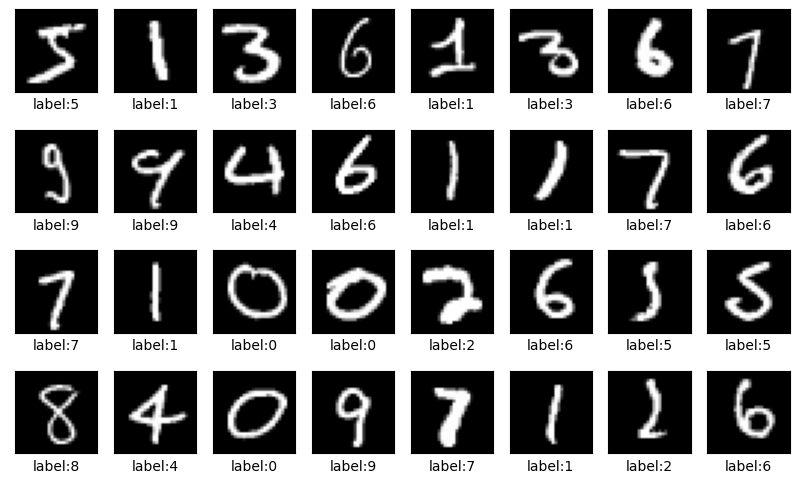

In [14]:
mnist = fetch_openml('mnist_784', version=1, cache=True)

images = mnist.data.to_numpy().reshape(-1, 28, 28)  
labels = mnist.target.to_numpy().astype(int)  

print("图片数据集维度：", images.shape)
print("特征数量：", len(labels))
print("标签数量：",len(np.unique(labels)))

_, axes = plt.subplots(4,8,figsize=(10,6))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(images[i*6],cmap='gray')
    
    ax.set_xlabel(f'label:{labels[i*6]}')
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

LDMGI
max acc: 0.65
max nmi: 0.6442513628170438
mean acc: 0.6360000000000001 ± 0.01651934892448517
mean nmi: 0.6323518309906128 ± 0.013512207590173726
KMeans
max acc: 0.56
max nmi: 0.534632265192505
mean acc: 0.5600000000000002 ± 1.1102230246251565e-16
mean nmi: 0.5326443399160163 ± 0.0059637758294656335
DisKmeans
max acc: 0.49333333333333335
max nmi: 0.44092026147945923
mean acc: 0.4746666666666666 ± 0.02286190426597634
mean nmi: 0.4359592387200045 ± 0.0060780301814534225
NCut
max acc: 0.6
max nmi: 0.6103737733712408
mean acc: 0.5643333333333332 ± 0.030001851794699455
mean nmi: 0.5615549245555458 ± 0.03708225115922638
LLC_G
max acc: 0.5566666666666666
max nmi: 0.5644880802284713
mean acc: 0.5479999999999999 ± 0.010666666666666666
mean nmi: 0.5432670102940191 ± 0.028574074926814914
LLC_L
max acc: 0.5433333333333333
max nmi: 0.5146201986726305
mean acc: 0.518 ± 0.0310268700752536
mean nmi: 0.4933032935357364 ± 0.01996882809788993


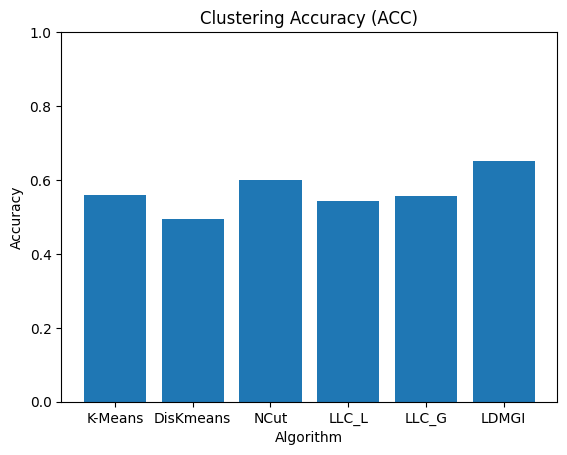

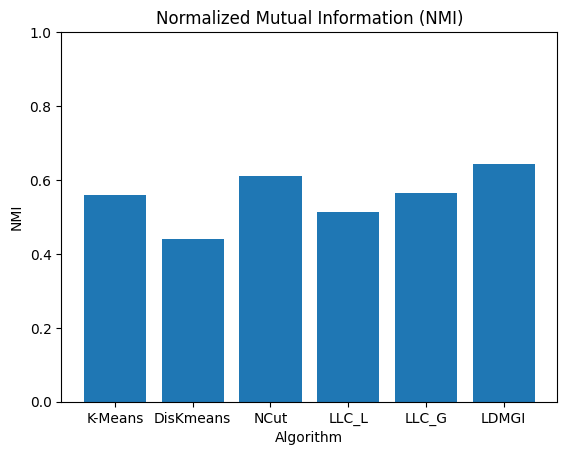

ACC_scores: [0.56, 0.49333333333333335, 0.6, 0.5433333333333333, 0.5566666666666666, 0.65]
NMI_scores: [0.56, 0.44092026147945923, 0.6103737733712408, 0.5146201986726305, 0.5644880802284713, 0.6442513628170438]


In [15]:
ACC_scores = []
NMI_scores = []

nrounds_KMeans_acc,nrounds_KMeans_acc,nrounds_DisKmeans_accs,nrounds_DisKmeans_nmis,nrounds_NCut_accs,nrounds_NCut_nmis,nrounds_LLC_L_acc,nrounds_LLC_L_nmi,nrounds_LLC_G_accs,nrounds_LLC_G_nmis,nrounds_LDMGI_accs,nrounds_LDMGI_nmis = run_five_algos()

# K-Means Clustering

ACC_scores.append(nrounds_KMeans_acc)
NMI_scores.append(nrounds_KMeans_acc)

# DisKmeans
ACC_scores.append(max(nrounds_DisKmeans_accs))
NMI_scores.append(max(nrounds_DisKmeans_nmis))

# NCut
ACC_scores.append(max(nrounds_NCut_accs))
NMI_scores.append(max(nrounds_NCut_nmis))

# LLC_L

ACC_scores.append(nrounds_LLC_L_acc)
NMI_scores.append(nrounds_LLC_L_nmi)

# LLC_G
ACC_scores.append(max(nrounds_LLC_G_accs))
NMI_scores.append(max(nrounds_LLC_G_nmis))

# LDMGI with K-means
ACC_scores.append(max(nrounds_LDMGI_accs))
NMI_scores.append(max(nrounds_LDMGI_nmis))


plt.bar([ 'K-Means', 'DisKmeans', 'NCut','LLC_L','LLC_G','LDMGI'], ACC_scores)
plt.title('Clustering Accuracy (ACC)')
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.show()

plt.bar([ 'K-Means', 'DisKmeans', 'NCut','LLC_L','LLC_G','LDMGI'], NMI_scores)
plt.title('Normalized Mutual Information (NMI)')
plt.xlabel('Algorithm')
plt.ylabel('NMI')
plt.ylim([0, 1])
plt.show()

print("ACC_scores:",ACC_scores)
print("NMI_scores:",NMI_scores)

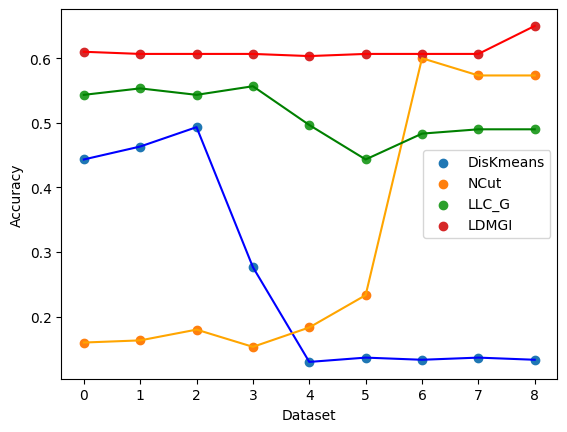

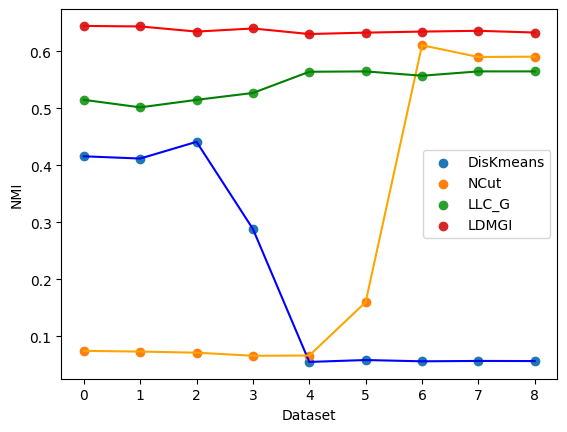

In [16]:
plt.scatter(range(len(nrounds_DisKmeans_accs)), nrounds_DisKmeans_accs, linestyle='-', label='DisKmeans')
plt.plot(range(len(nrounds_DisKmeans_accs)), nrounds_DisKmeans_accs, linestyle='-', color='blue')
plt.scatter(range(len(nrounds_NCut_accs)), nrounds_NCut_accs, linestyle='-', label='NCut')
plt.plot(range(len(nrounds_NCut_accs)), nrounds_NCut_accs, linestyle='-', color='orange')
plt.scatter(range(len(nrounds_LLC_G_accs)), nrounds_LLC_G_accs, linestyle='-', label='LLC_G')
plt.plot(range(len(nrounds_LLC_G_accs)), nrounds_LLC_G_accs, linestyle='-', color='green')
plt.scatter(range(len(nrounds_LDMGI_accs)), nrounds_LDMGI_accs, linestyle='-', label='LDMGI')
plt.plot(range(len(nrounds_LDMGI_accs)), nrounds_LDMGI_accs, linestyle='-', color='red')

plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.scatter(range(len(nrounds_DisKmeans_nmis)), nrounds_DisKmeans_nmis, linestyle='-', label='DisKmeans')
plt.plot(range(len(nrounds_DisKmeans_nmis)), nrounds_DisKmeans_nmis, linestyle='-', color='blue')
plt.scatter(range(len(nrounds_NCut_nmis)), nrounds_NCut_nmis, linestyle='-', label='NCut')
plt.plot(range(len(nrounds_NCut_nmis)), nrounds_NCut_nmis, linestyle='-', color='orange')
plt.scatter(range(len(nrounds_LLC_G_nmis)), nrounds_LLC_G_nmis, linestyle='-', label='LLC_G')
plt.plot(range(len(nrounds_LLC_G_nmis)), nrounds_LLC_G_nmis, linestyle='-', color='green')
plt.scatter(range(len(nrounds_LDMGI_nmis)), nrounds_LDMGI_nmis, linestyle='-', label='LDMGI')
plt.plot(range(len(nrounds_LDMGI_nmis)), nrounds_LDMGI_nmis, linestyle='-', color='red')

plt.xlabel('Dataset')
plt.ylabel('NMI')
plt.legend()
plt.show()

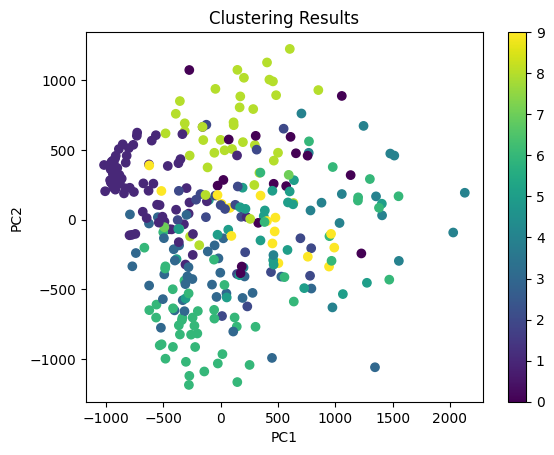

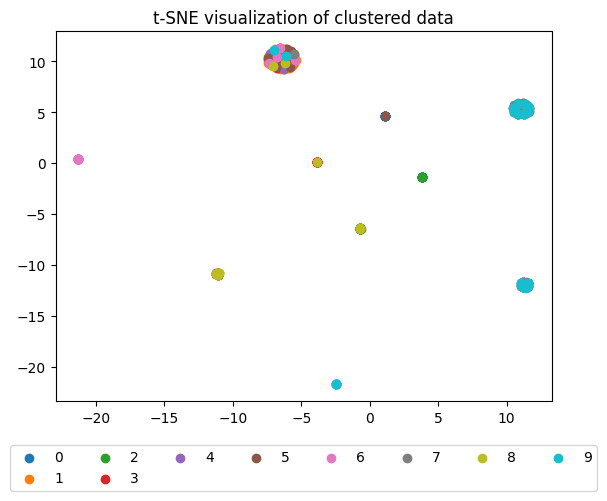

In [17]:
# The intuitive impression of LDMGI clustering results 1 
X = images
Y = LDMGI(X = images,k = 5,c =n_clusters)
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Clustering Results Visualization Plot
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Y.argmax(axis=1))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clustering Results')
plt.colorbar()
plt.show()
# The intuitive impression of LDMGI clustering results 2 
X = images
y = labels

Y = LDMGI(X, k=5, c =n_clusters)

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(Y)

for i in range(n_clusters):
    plt.scatter(X_tsne[y==i, 0], X_tsne[y==i, 1], label=i)
plt.title('t-SNE visualization of clustered data')
plt.legend(ncol=8, bbox_to_anchor=(0.5, -0.1), loc='upper center')
plt.show()

图片数据集维度： (1797, 8, 8)
特征数量： 1797
标签数量： 10


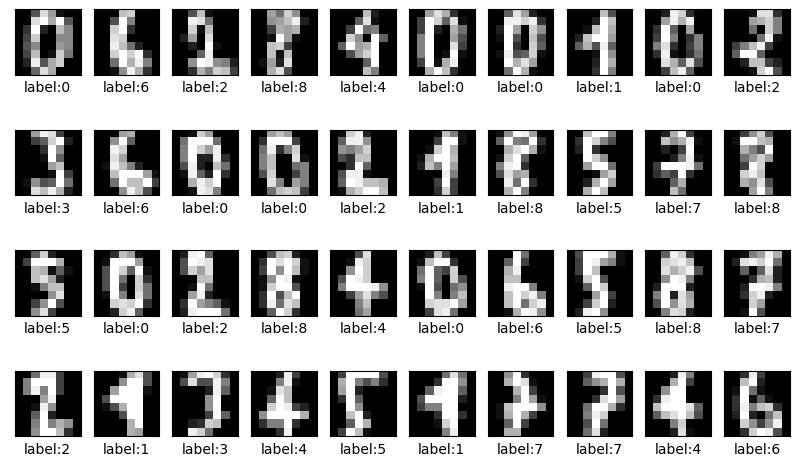

In [27]:
dataset = load_digits()
images = dataset.images
labels = dataset.target
print("图片数据集维度：", images.shape)
print("特征数量：", len(labels))
print("标签数量：",len(np.unique(labels)))


_, axes = plt.subplots(4,10,figsize=(10,6))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(images[i*6],cmap='gray')
    
    ax.set_xlabel(f'label:{labels[i*6]}')
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

LDMGI
max acc: 0.9133333333333333
max nmi: 0.8717698749686635
mean acc: 0.9133333333333334 ± 1.1102230246251565e-16
mean nmi: 0.8717698749686635 ± 0.0
KMeans
max acc: 0.7833333333333333
max nmi: 0.7855013848468001
mean acc: 0.7683333333333333 ± 0.019677962857527258
mean nmi: 0.7689313907853121 ± 0.02060345326553121
DisKmeans
max acc: 0.8
max nmi: 0.7557479291943204
mean acc: 0.7593333333333334 ± 0.03017725412735007
mean nmi: 0.7448807201567591 ± 0.015136334861679318
NCut
max acc: 0.8466666666666667
max nmi: 0.8229978922313148
mean acc: 0.8313333333333333 ± 0.031559467676119016
mean nmi: 0.8089082742640515 ± 0.028237558830807072
LLC_G
max acc: 0.88
max nmi: 0.8528958659670554
mean acc: 0.8736666666666666 ± 0.019000000000000006
mean nmi: 0.851626775999357 ± 0.002538179935396689
LLC_L
max acc: 0.7966666666666666
max nmi: 0.832281527057533
mean acc: 0.7966666666666666 ± 0.0
mean nmi: 0.832281527057533 ± 0.0


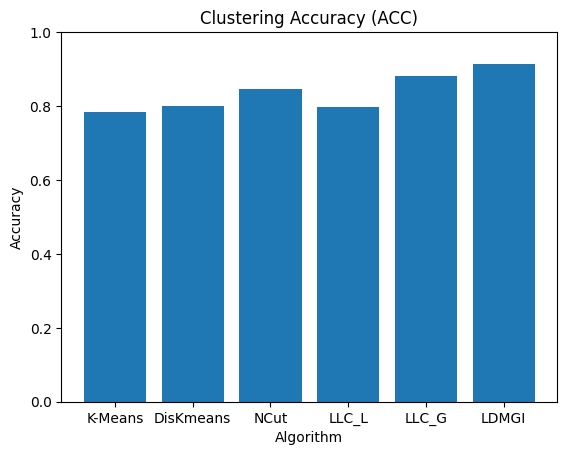

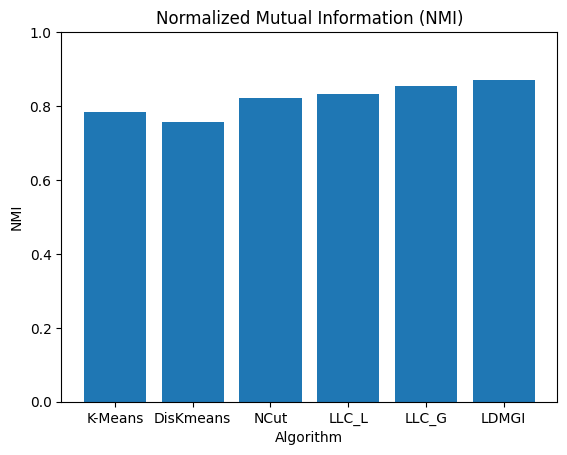

ACC_scores: [0.7833333333333333, 0.8, 0.8466666666666667, 0.7966666666666666, 0.88, 0.9133333333333333]
NMI_scores: [0.7833333333333333, 0.7557479291943204, 0.8229978922313148, 0.832281527057533, 0.8528958659670554, 0.8717698749686635]


In [28]:
ACC_scores = []
NMI_scores = []

nrounds_KMeans_acc,nrounds_KMeans_acc,nrounds_DisKmeans_accs,nrounds_DisKmeans_nmis,nrounds_NCut_accs,nrounds_NCut_nmis,nrounds_LLC_L_acc,nrounds_LLC_L_nmi,nrounds_LLC_G_accs,nrounds_LLC_G_nmis,nrounds_LDMGI_accs,nrounds_LDMGI_nmis = run_five_algos()

# K-Means Clustering

ACC_scores.append(nrounds_KMeans_acc)
NMI_scores.append(nrounds_KMeans_acc)

# DisKmeans
ACC_scores.append(max(nrounds_DisKmeans_accs))
NMI_scores.append(max(nrounds_DisKmeans_nmis))

# NCut
ACC_scores.append(max(nrounds_NCut_accs))
NMI_scores.append(max(nrounds_NCut_nmis))

# LLC_L

ACC_scores.append(nrounds_LLC_L_acc)
NMI_scores.append(nrounds_LLC_L_nmi)

# LLC_G
ACC_scores.append(max(nrounds_LLC_G_accs))
NMI_scores.append(max(nrounds_LLC_G_nmis))

# LDMGI with K-means
ACC_scores.append(max(nrounds_LDMGI_accs))
NMI_scores.append(max(nrounds_LDMGI_nmis))

plt.bar([ 'K-Means', 'DisKmeans', 'NCut','LLC_L','LLC_G','LDMGI'], ACC_scores)
plt.title('Clustering Accuracy (ACC)')
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.show()

plt.bar([ 'K-Means', 'DisKmeans', 'NCut','LLC_L','LLC_G','LDMGI'], NMI_scores)
plt.title('Normalized Mutual Information (NMI)')
plt.xlabel('Algorithm')
plt.ylabel('NMI')
plt.ylim([0, 1])
plt.show()

print("ACC_scores:",ACC_scores)
print("NMI_scores:",NMI_scores)

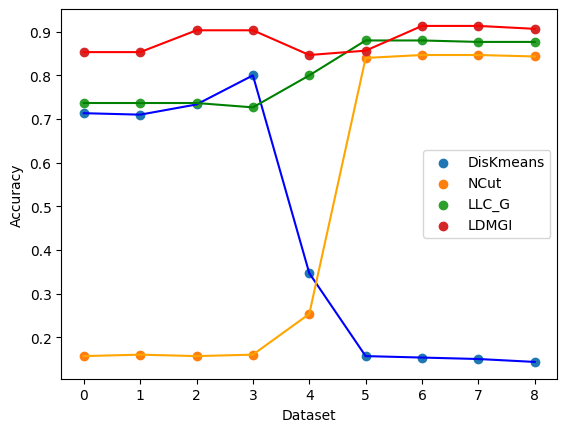

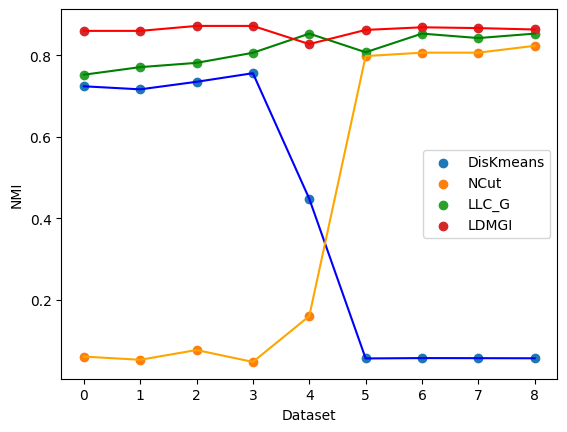

In [29]:
plt.scatter(range(len(nrounds_DisKmeans_accs)), nrounds_DisKmeans_accs, linestyle='-', label='DisKmeans')
plt.plot(range(len(nrounds_DisKmeans_accs)), nrounds_DisKmeans_accs, linestyle='-', color='blue')
plt.scatter(range(len(nrounds_NCut_accs)), nrounds_NCut_accs, linestyle='-', label='NCut')
plt.plot(range(len(nrounds_NCut_accs)), nrounds_NCut_accs, linestyle='-', color='orange')
plt.scatter(range(len(nrounds_LLC_G_accs)), nrounds_LLC_G_accs, linestyle='-', label='LLC_G')
plt.plot(range(len(nrounds_LLC_G_accs)), nrounds_LLC_G_accs, linestyle='-', color='green')
plt.scatter(range(len(nrounds_LDMGI_accs)), nrounds_LDMGI_accs, linestyle='-', label='LDMGI')
plt.plot(range(len(nrounds_LDMGI_accs)), nrounds_LDMGI_accs, linestyle='-', color='red')

plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.scatter(range(len(nrounds_DisKmeans_nmis)), nrounds_DisKmeans_nmis, linestyle='-', label='DisKmeans')
plt.plot(range(len(nrounds_DisKmeans_nmis)), nrounds_DisKmeans_nmis, linestyle='-', color='blue')
plt.scatter(range(len(nrounds_NCut_nmis)), nrounds_NCut_nmis, linestyle='-', label='NCut')
plt.plot(range(len(nrounds_NCut_nmis)), nrounds_NCut_nmis, linestyle='-', color='orange')
plt.scatter(range(len(nrounds_LLC_G_nmis)), nrounds_LLC_G_nmis, linestyle='-', label='LLC_G')
plt.plot(range(len(nrounds_LLC_G_nmis)), nrounds_LLC_G_nmis, linestyle='-', color='green')
plt.scatter(range(len(nrounds_LDMGI_nmis)), nrounds_LDMGI_nmis, linestyle='-', label='LDMGI')
plt.plot(range(len(nrounds_LDMGI_nmis)), nrounds_LDMGI_nmis, linestyle='-', color='red')

plt.xlabel('Dataset')
plt.ylabel('NMI')
plt.legend()
plt.show()

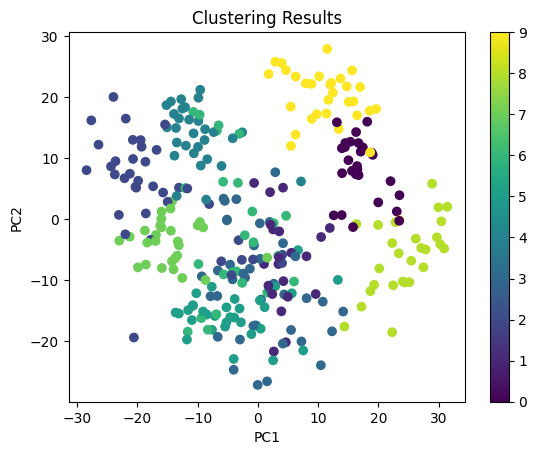

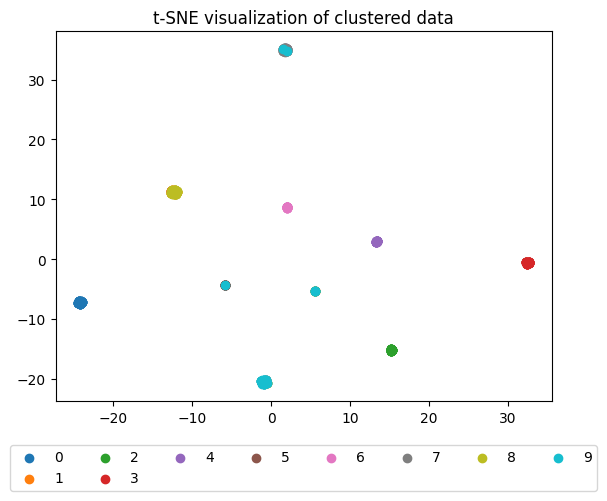

In [30]:
# The intuitive impression of LDMGI clustering results 1 
X = images
Y = LDMGI(X = images,k = 5,c =n_clusters)
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Clustering Results Visualization Plot
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Y.argmax(axis=1))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clustering Results')
plt.colorbar()
plt.show()
# The intuitive impression of LDMGI clustering results 2 
X = images
y = labels

Y = LDMGI(X, k=5, c =n_clusters)

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(Y)

for i in range(n_clusters):
    plt.scatter(X_tsne[y==i, 0], X_tsne[y==i, 1], label=i)
plt.title('t-SNE visualization of clustered data')
plt.legend(ncol=8, bbox_to_anchor=(0.5, -0.1), loc='upper center')
plt.show()


图片数据集维度： (9298, 16, 16)
特征数量： 9298
标签数量： 10


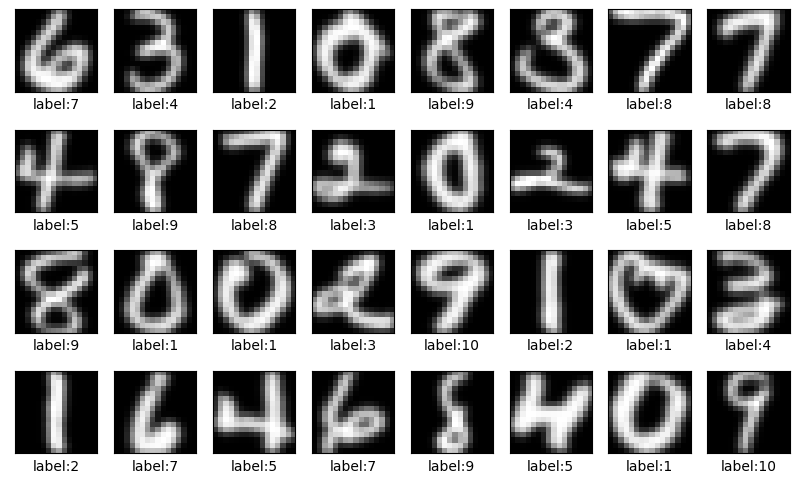

In [31]:
usps = fetch_openml('usps', version=2, cache=True)

images = usps.data.to_numpy().reshape(-1, 16,16)  
labels = usps.target.to_numpy().astype(int)  

print("图片数据集维度：", images.shape)
print("特征数量：", len(labels))
print("标签数量：",len(np.unique(labels)))

_, axes = plt.subplots(4,8,figsize=(10,6))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(images[i*6],cmap='gray')
    
    ax.set_xlabel(f'label:{labels[i*6]}')
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

LDMGI
max acc: 0.8
max nmi: 0.7686884158218932
mean acc: 0.7553333333333333 ± 0.03754108860080291
mean nmi: 0.7575860635450029 ± 0.013615674811588022
KMeans
max acc: 0.65
max nmi: 0.6505696890843543
mean acc: 0.6333333333333335 ± 0.02049390153191919
mean nmi: 0.6436755592078288 ± 0.020682389629576307
DisKmeans
max acc: 0.58
max nmi: 0.544708779843245
mean acc: 0.5640000000000001 ± 0.018844392033470072
mean nmi: 0.5349139487737649 ± 0.009628123398710473
NCut
max acc: 0.69
max nmi: 0.7214188653843885
mean acc: 0.649 ± 0.03627211968808363
mean nmi: 0.7056186456556304 ± 0.019351238079656486
LLC_G
max acc: 0.7
max nmi: 0.6872776505715352
mean acc: 0.6903333333333334 ± 0.024695928589321924
mean nmi: 0.6852895104575406 ± 0.005780532482994646
LLC_L
max acc: 0.6466666666666666
max nmi: 0.6872776505715352
mean acc: 0.6186666666666666 ± 0.05770037550426627
mean nmi: 0.6626503386967261 ± 0.050523600114129354


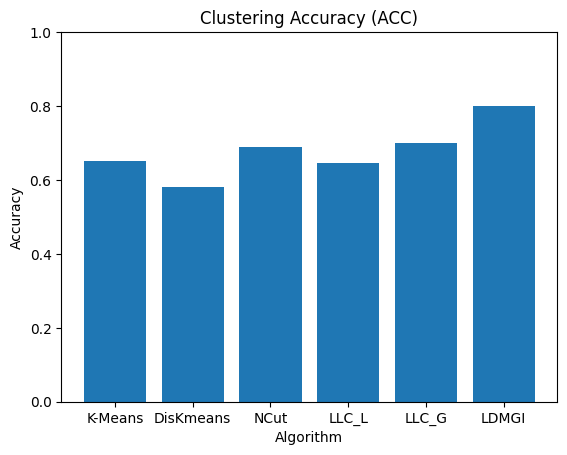

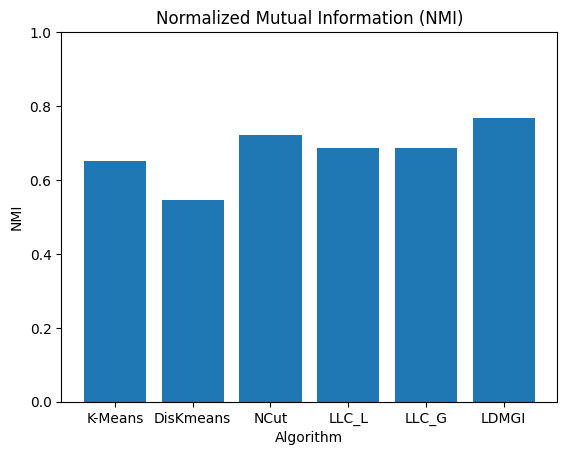

ACC_scores: [0.65, 0.58, 0.69, 0.6466666666666666, 0.7, 0.8]
NMI_scores: [0.65, 0.544708779843245, 0.7214188653843885, 0.6872776505715352, 0.6872776505715352, 0.7686884158218932]


In [32]:
ACC_scores = []
NMI_scores = []

nrounds_KMeans_acc,nrounds_KMeans_acc,nrounds_DisKmeans_accs,nrounds_DisKmeans_nmis,nrounds_NCut_accs,nrounds_NCut_nmis,nrounds_LLC_L_acc,nrounds_LLC_L_nmi,nrounds_LLC_G_accs,nrounds_LLC_G_nmis,nrounds_LDMGI_accs,nrounds_LDMGI_nmis = run_five_algos()

# K-Means Clustering

ACC_scores.append(nrounds_KMeans_acc)
NMI_scores.append(nrounds_KMeans_acc)

# DisKmeans
ACC_scores.append(max(nrounds_DisKmeans_accs))
NMI_scores.append(max(nrounds_DisKmeans_nmis))

# NCut
ACC_scores.append(max(nrounds_NCut_accs))
NMI_scores.append(max(nrounds_NCut_nmis))

# LLC_L

ACC_scores.append(nrounds_LLC_L_acc)
NMI_scores.append(nrounds_LLC_L_nmi)

# LLC_G
ACC_scores.append(max(nrounds_LLC_G_accs))
NMI_scores.append(max(nrounds_LLC_G_nmis))

# LDMGI with K-means
ACC_scores.append(max(nrounds_LDMGI_accs))
NMI_scores.append(max(nrounds_LDMGI_nmis))

plt.bar([ 'K-Means', 'DisKmeans', 'NCut','LLC_L','LLC_G','LDMGI'], ACC_scores)
plt.title('Clustering Accuracy (ACC)')
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.show()


plt.bar([ 'K-Means', 'DisKmeans', 'NCut','LLC_L','LLC_G','LDMGI'], NMI_scores)
plt.title('Normalized Mutual Information (NMI)')
plt.xlabel('Algorithm')
plt.ylabel('NMI')
plt.ylim([0, 1])
plt.show()

print("ACC_scores:",ACC_scores)
print("NMI_scores:",NMI_scores)

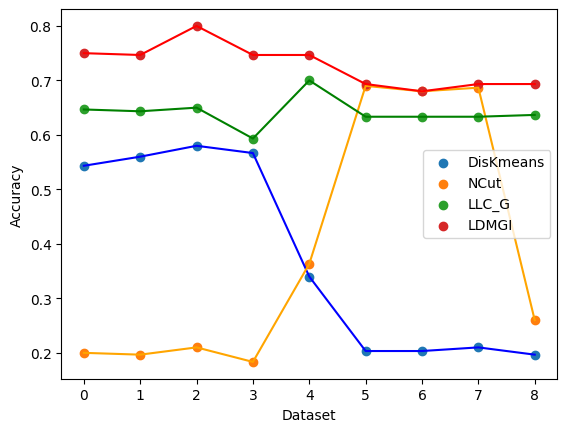

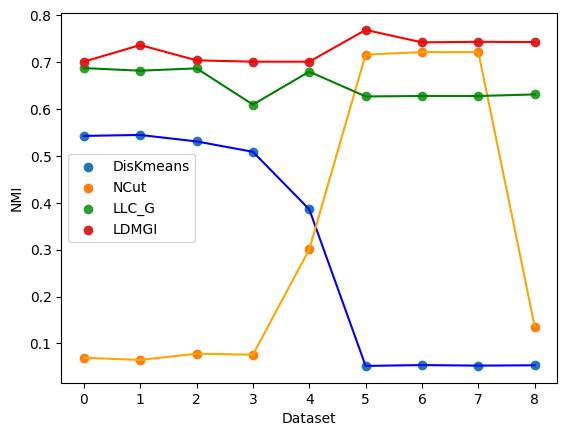

In [33]:
plt.scatter(range(len(nrounds_DisKmeans_accs)), nrounds_DisKmeans_accs, linestyle='-', label='DisKmeans')
plt.plot(range(len(nrounds_DisKmeans_accs)), nrounds_DisKmeans_accs, linestyle='-', color='blue')
plt.scatter(range(len(nrounds_NCut_accs)), nrounds_NCut_accs, linestyle='-', label='NCut')
plt.plot(range(len(nrounds_NCut_accs)), nrounds_NCut_accs, linestyle='-', color='orange')
plt.scatter(range(len(nrounds_LLC_G_accs)), nrounds_LLC_G_accs, linestyle='-', label='LLC_G')
plt.plot(range(len(nrounds_LLC_G_accs)), nrounds_LLC_G_accs, linestyle='-', color='green')
plt.scatter(range(len(nrounds_LDMGI_accs)), nrounds_LDMGI_accs, linestyle='-', label='LDMGI')
plt.plot(range(len(nrounds_LDMGI_accs)), nrounds_LDMGI_accs, linestyle='-', color='red')

plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.scatter(range(len(nrounds_DisKmeans_nmis)), nrounds_DisKmeans_nmis, linestyle='-', label='DisKmeans')
plt.plot(range(len(nrounds_DisKmeans_nmis)), nrounds_DisKmeans_nmis, linestyle='-', color='blue')
plt.scatter(range(len(nrounds_NCut_nmis)), nrounds_NCut_nmis, linestyle='-', label='NCut')
plt.plot(range(len(nrounds_NCut_nmis)), nrounds_NCut_nmis, linestyle='-', color='orange')
plt.scatter(range(len(nrounds_LLC_G_nmis)), nrounds_LLC_G_nmis, linestyle='-', label='LLC_G')
plt.plot(range(len(nrounds_LLC_G_nmis)), nrounds_LLC_G_nmis, linestyle='-', color='green')
plt.scatter(range(len(nrounds_LDMGI_nmis)), nrounds_LDMGI_nmis, linestyle='-', label='LDMGI')
plt.plot(range(len(nrounds_LDMGI_nmis)), nrounds_LDMGI_nmis, linestyle='-', color='red')

plt.xlabel('Dataset')
plt.ylabel('NMI')
plt.legend()
plt.show()

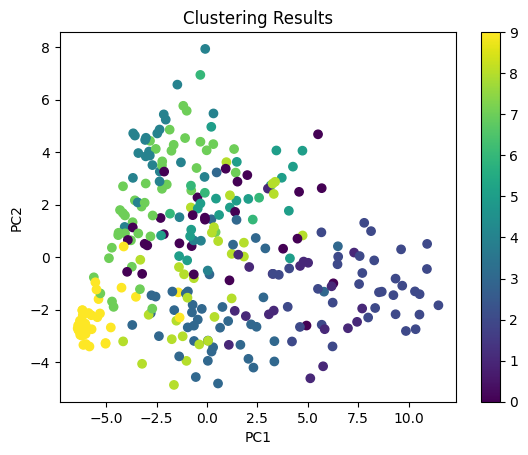

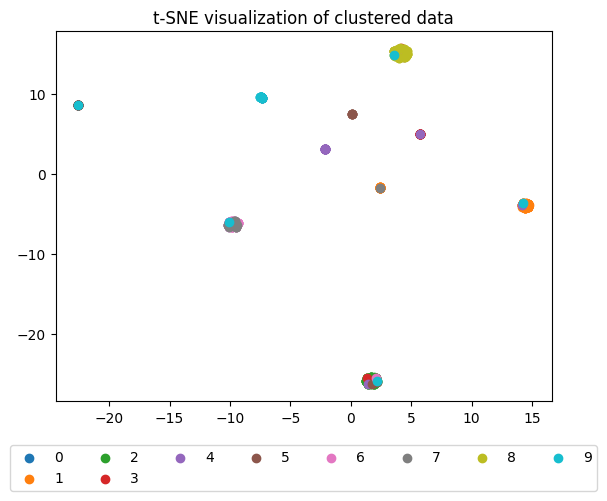

In [34]:
# The intuitive impression of LDMGI clustering results 1 
X = images
Y = LDMGI(X = images,k = 5,c =n_clusters)
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Clustering Results Visualization Plot
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Y.argmax(axis=1))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clustering Results')
plt.colorbar()
plt.show()
# The intuitive impression of LDMGI clustering results 2 
X = images
y = labels

Y = LDMGI(X, k=5, c =n_clusters)

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(Y)

for i in range(n_clusters):
    plt.scatter(X_tsne[y==i, 0], X_tsne[y==i, 1], label=i)
plt.title('t-SNE visualization of clustered data')
plt.legend(ncol=8, bbox_to_anchor=(0.5, -0.1), loc='upper center')
plt.show()

图片数据集维度： (575, 92, 92)
特征数量： 575
标签数量： 20


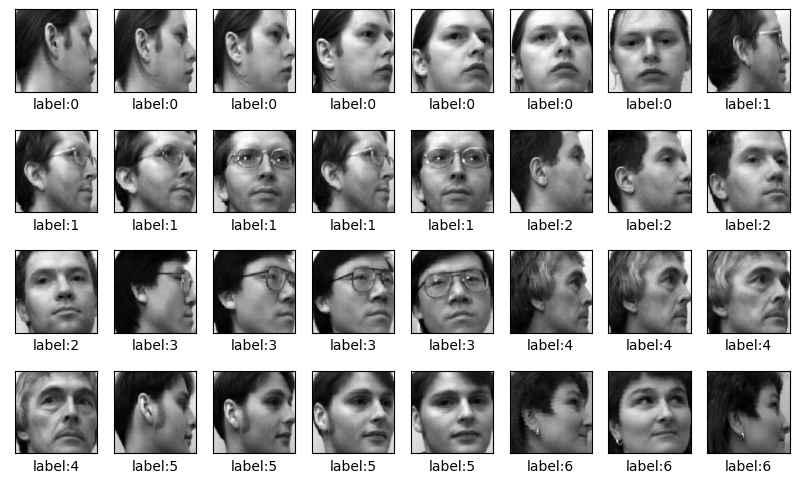

In [41]:
umist = fetch_openml('UMIST_Faces_Cropped', cache=True)

images = umist.data.to_numpy().reshape(-1,112,92)  
labels = umist.target.to_numpy().astype(int)  

cropped_images = np.zeros((images.shape[0], 92, 92))

for i in range(images.shape[0]):
    original_image = images[i]
    start_x = (original_image.shape[1] - 92) // 2
    start_y = (original_image.shape[0] - 92) // 2
    cropped_image = original_image[start_y:start_y+92, start_x:start_x+92]
    cropped_images[i] = cropped_image

images = cropped_images
print("图片数据集维度：", images.shape)
print("特征数量：", len(labels))
print("标签数量：",len(np.unique(labels)))

_, axes = plt.subplots(4,8,figsize=(10,6))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(images[i*6],cmap='gray')
    
    ax.set_xlabel(f'label:{labels[i*6]}')
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

LDMGI
max acc: 0.64
max nmi: 0.7819802132839176
mean acc: 0.6319999999999999 ± 0.016000000000000014
mean nmi: 0.7760210729334759 ± 0.011918280700883433
KMeans
max acc: 0.47
max nmi: 0.6741751332348063
mean acc: 0.45233333333333325 ± 0.022113344387495973
mean nmi: 0.6549002652471335 ± 0.025119376975273788
DisKmeans
max acc: 0.47333333333333333
max nmi: 0.6750312648535292
mean acc: 0.46133333333333343 ± 0.012036980056845187
mean nmi: 0.6614657272254771 ± 0.013736301193906546
NCut
max acc: 0.5266666666666666
max nmi: 0.7057911719627226
mean acc: 0.5253333333333332 ± 0.0026666666666666393
mean nmi: 0.7057911719627226 ± 0.0
LLC_G
max acc: 0.5533333333333333
max nmi: 0.7239709926405072
mean acc: 0.5433333333333333 ± 0.010000000000000009
mean nmi: 0.7212654596249939 ± 0.005411066031026701
LLC_L
max acc: 0.5
max nmi: 0.6850583952645587
mean acc: 0.4926666666666667 ± 0.014666666666666673
mean nmi: 0.684071125033415 ± 0.0009877826388685496


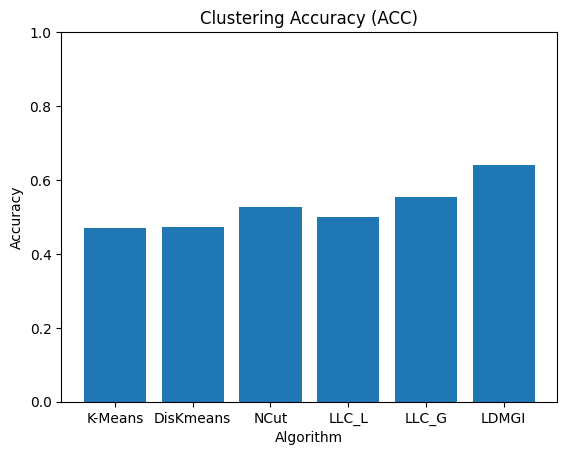

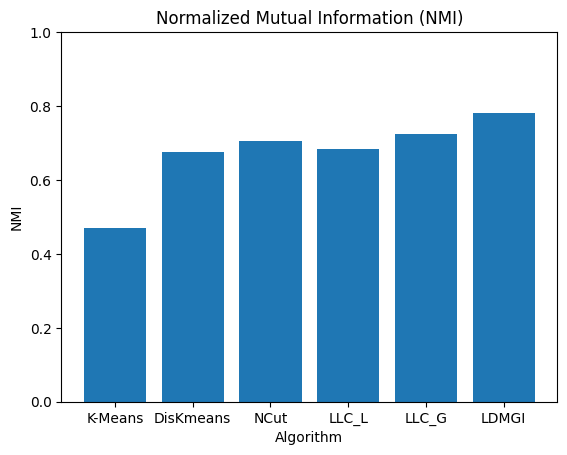

ACC_scores: [0.47, 0.47333333333333333, 0.5266666666666666, 0.5, 0.5533333333333333, 0.64]
NMI_scores: [0.47, 0.6750312648535292, 0.7057911719627226, 0.6850583952645587, 0.7239709926405072, 0.7819802132839176]


In [42]:
ACC_scores = []
NMI_scores = []

nrounds_KMeans_acc,nrounds_KMeans_acc,nrounds_DisKmeans_accs,nrounds_DisKmeans_nmis,nrounds_NCut_accs,nrounds_NCut_nmis,nrounds_LLC_L_acc,nrounds_LLC_L_nmi,nrounds_LLC_G_accs,nrounds_LLC_G_nmis,nrounds_LDMGI_accs,nrounds_LDMGI_nmis = run_five_algos()

# K-Means Clustering

ACC_scores.append(nrounds_KMeans_acc)
NMI_scores.append(nrounds_KMeans_acc)

# DisKmeans
ACC_scores.append(max(nrounds_DisKmeans_accs))
NMI_scores.append(max(nrounds_DisKmeans_nmis))

# NCut
ACC_scores.append(max(nrounds_NCut_accs))
NMI_scores.append(max(nrounds_NCut_nmis))

# LLC_L

ACC_scores.append(nrounds_LLC_L_acc)
NMI_scores.append(nrounds_LLC_L_nmi)

# LLC_G
ACC_scores.append(max(nrounds_LLC_G_accs))
NMI_scores.append(max(nrounds_LLC_G_nmis))

# LDMGI with K-means
ACC_scores.append(max(nrounds_LDMGI_accs))
NMI_scores.append(max(nrounds_LDMGI_nmis))

plt.bar([ 'K-Means', 'DisKmeans', 'NCut','LLC_L','LLC_G','LDMGI'], ACC_scores)
plt.title('Clustering Accuracy (ACC)')
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.show()

plt.bar([ 'K-Means', 'DisKmeans', 'NCut','LLC_L','LLC_G','LDMGI'], NMI_scores)
plt.title('Normalized Mutual Information (NMI)')
plt.xlabel('Algorithm')
plt.ylabel('NMI')
plt.ylim([0, 1])
plt.show()

print("ACC_scores:",ACC_scores)
print("NMI_scores:",NMI_scores)

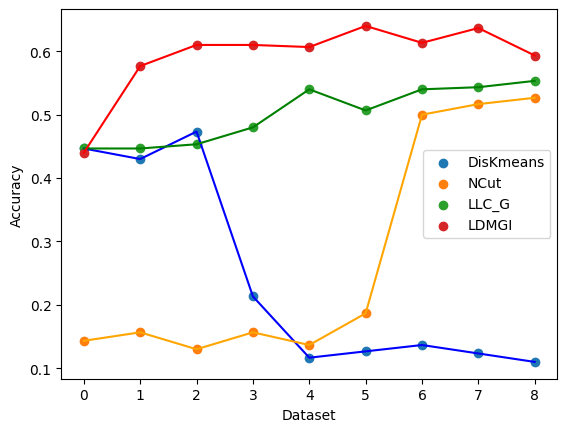

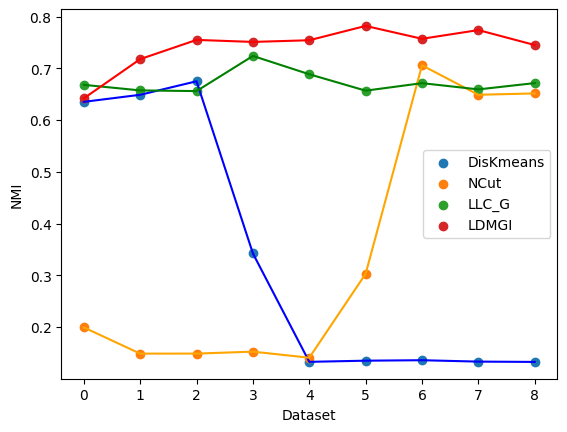

In [43]:
plt.scatter(range(len(nrounds_DisKmeans_accs)), nrounds_DisKmeans_accs, linestyle='-', label='DisKmeans')
plt.plot(range(len(nrounds_DisKmeans_accs)), nrounds_DisKmeans_accs, linestyle='-', color='blue')
plt.scatter(range(len(nrounds_NCut_accs)), nrounds_NCut_accs, linestyle='-', label='NCut')
plt.plot(range(len(nrounds_NCut_accs)), nrounds_NCut_accs, linestyle='-', color='orange')
plt.scatter(range(len(nrounds_LLC_G_accs)), nrounds_LLC_G_accs, linestyle='-', label='LLC_G')
plt.plot(range(len(nrounds_LLC_G_accs)), nrounds_LLC_G_accs, linestyle='-', color='green')
plt.scatter(range(len(nrounds_LDMGI_accs)), nrounds_LDMGI_accs, linestyle='-', label='LDMGI')
plt.plot(range(len(nrounds_LDMGI_accs)), nrounds_LDMGI_accs, linestyle='-', color='red')

plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.scatter(range(len(nrounds_DisKmeans_nmis)), nrounds_DisKmeans_nmis, linestyle='-', label='DisKmeans')
plt.plot(range(len(nrounds_DisKmeans_nmis)), nrounds_DisKmeans_nmis, linestyle='-', color='blue')
plt.scatter(range(len(nrounds_NCut_nmis)), nrounds_NCut_nmis, linestyle='-', label='NCut')
plt.plot(range(len(nrounds_NCut_nmis)), nrounds_NCut_nmis, linestyle='-', color='orange')
plt.scatter(range(len(nrounds_LLC_G_nmis)), nrounds_LLC_G_nmis, linestyle='-', label='LLC_G')
plt.plot(range(len(nrounds_LLC_G_nmis)), nrounds_LLC_G_nmis, linestyle='-', color='green')
plt.scatter(range(len(nrounds_LDMGI_nmis)), nrounds_LDMGI_nmis, linestyle='-', label='LDMGI')
plt.plot(range(len(nrounds_LDMGI_nmis)), nrounds_LDMGI_nmis, linestyle='-', color='red')

plt.xlabel('Dataset')
plt.ylabel('NMI')
plt.legend()
plt.show()

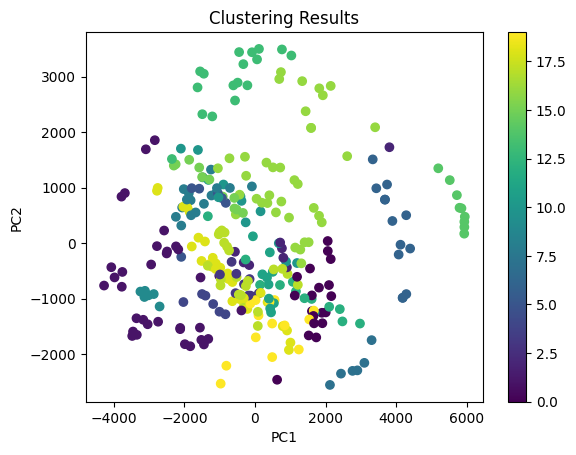

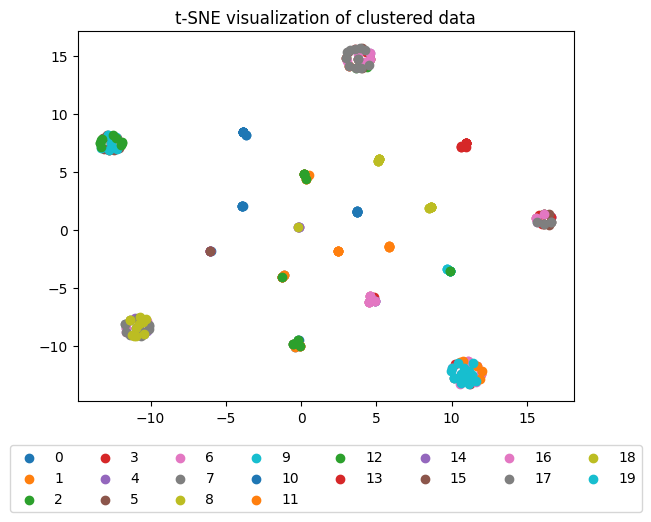

In [44]:
# The intuitive impression of LDMGI clustering results 1 
X = images
Y = LDMGI(X = images,k = 5,c =n_clusters)
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Clustering Results Visualization Plot
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Y.argmax(axis=1))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clustering Results')
plt.colorbar()
plt.show()
# The intuitive impression of LDMGI clustering results 2 
X = images
y = labels

Y = LDMGI(X, k=5, c =n_clusters)

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(Y)

for i in range(n_clusters):
    plt.scatter(X_tsne[y==i, 0], X_tsne[y==i, 1], label=i)
plt.title('t-SNE visualization of clustered data')
plt.legend(ncol=8, bbox_to_anchor=(0.5, -0.1), loc='upper center')
plt.show()

图片数据集维度： (1400, 32, 32)
特征数量： 1400
标签数量： 70


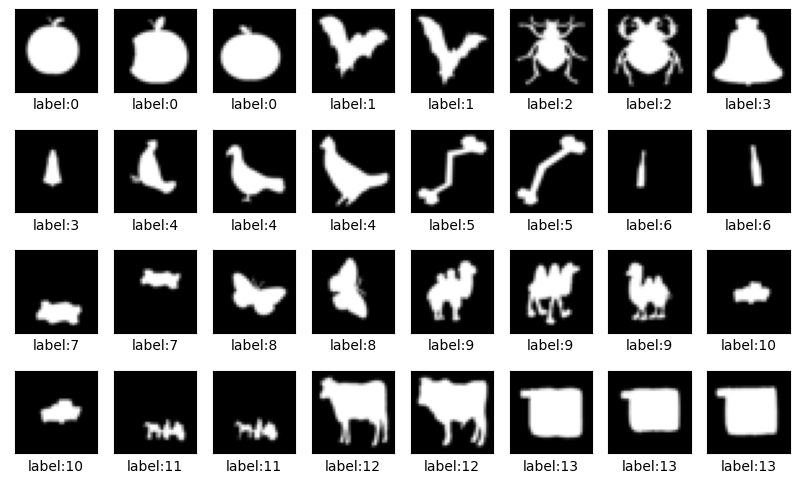

In [50]:
def load_dataset():
    data = []
    all_imgs_path = glob.glob(r'C:\Users\32204\Desktop\1400_mpeg7-master\*.png')
    for ip in all_imgs_path:
        data.append(ip)
    labels = []
    for i in range(70):
        labels.extend([i] * 20)
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
    ])
    dataset = []
    for i in range(len(labels)):
        temp_img = Image.open(data[i])
        temp_img = transform(temp_img)
        temp_array = np.array(temp_img)
        dataset.append(temp_array)
    dataset = np.stack(dataset, axis=0)  
    return dataset,labels

images,labels = load_dataset() 
labels = np.array(labels)

print("图片数据集维度：", images.shape)
print("特征数量：", len(labels))
print("标签数量：",len(np.unique(labels)))

_, axes = plt.subplots(4,8,figsize=(10,6))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(images[i*9],cmap='gray')
    
    ax.set_xlabel(f'label:{labels[i*9]}')
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()


LDMGI
max acc: 0.6444444444444445
max nmi: 0.8103554671099206
mean acc: 0.6444444444444446 ± 1.1102230246251565e-16
mean nmi: 0.8103554671099206 ± 0.0
KMeans
max acc: 0.6088888888888889
max nmi: 0.7960074636647427
mean acc: 0.6043333333333335 ± 0.0051267875533597
mean nmi: 0.7938644738905912 ± 0.004155529078007898
DisKmeans
max acc: 0.5111111111111111
max nmi: 0.7342513914200071
mean acc: 0.5025555555555556 ± 0.00883385742680042
mean nmi: 0.7317661929274696 ± 0.007455595477612398
NCut
max acc: 0.2288888888888889
max nmi: 0.4985442888728081
mean acc: 0.22622222222222219 ± 0.005333333333333335
mean nmi: 0.49578598706163096 ± 0.001872288718636993
LLC_G
max acc: 0.6155555555555555
max nmi: 0.7912934396130006
mean acc: 0.6115555555555556 ± 0.006110100926607775
mean nmi: 0.7906477247740236 ± 0.0009172520956533792
LLC_L
max acc: 0.2388888888888889
max nmi: 0.5492560069038176
mean acc: 0.23555555555555557 ± 0.003333333333333341
mean nmi: 0.5251824928921998 ± 0.024073514011617836


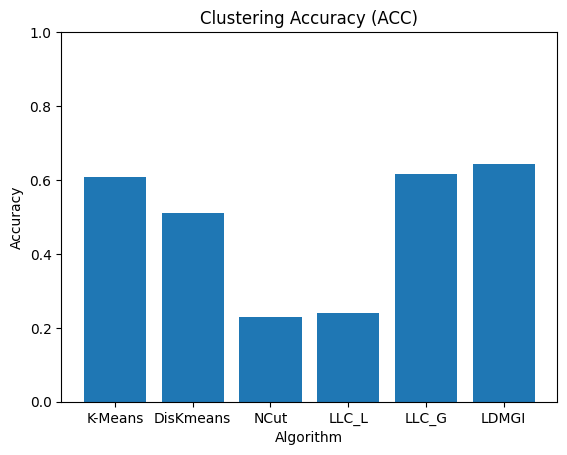

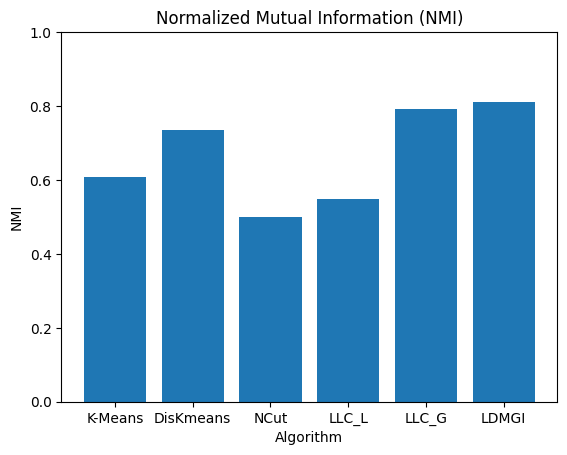

ACC_scores: [0.6088888888888889, 0.5111111111111111, 0.2288888888888889, 0.2388888888888889, 0.6155555555555555, 0.6444444444444445]
NMI_scores: [0.6088888888888889, 0.7342513914200071, 0.4985442888728081, 0.5492560069038176, 0.7912934396130006, 0.8103554671099206]


In [51]:
ACC_scores = []
NMI_scores = []

nrounds_KMeans_acc,nrounds_KMeans_acc,nrounds_DisKmeans_accs,nrounds_DisKmeans_nmis,nrounds_NCut_accs,nrounds_NCut_nmis,nrounds_LLC_L_acc,nrounds_LLC_L_nmi,nrounds_LLC_G_accs,nrounds_LLC_G_nmis,nrounds_LDMGI_accs,nrounds_LDMGI_nmis = run_five_algos()

# K-Means Clustering

ACC_scores.append(nrounds_KMeans_acc)
NMI_scores.append(nrounds_KMeans_acc)

# DisKmeans
ACC_scores.append(max(nrounds_DisKmeans_accs))
NMI_scores.append(max(nrounds_DisKmeans_nmis))

# NCut
ACC_scores.append(max(nrounds_NCut_accs))
NMI_scores.append(max(nrounds_NCut_nmis))

# LLC_L

ACC_scores.append(nrounds_LLC_L_acc)
NMI_scores.append(nrounds_LLC_L_nmi)

# LLC_G
ACC_scores.append(max(nrounds_LLC_G_accs))
NMI_scores.append(max(nrounds_LLC_G_nmis))

# LDMGI with K-means
ACC_scores.append(max(nrounds_LDMGI_accs))
NMI_scores.append(max(nrounds_LDMGI_nmis))

plt.bar([ 'K-Means', 'DisKmeans', 'NCut','LLC_L','LLC_G','LDMGI'], ACC_scores)
plt.title('Clustering Accuracy (ACC)')
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.show()

plt.bar([ 'K-Means', 'DisKmeans', 'NCut','LLC_L','LLC_G','LDMGI'], NMI_scores)
plt.title('Normalized Mutual Information (NMI)')
plt.xlabel('Algorithm')
plt.ylabel('NMI')
plt.ylim([0, 1])
plt.show()

print("ACC_scores:",ACC_scores)
print("NMI_scores:",NMI_scores)

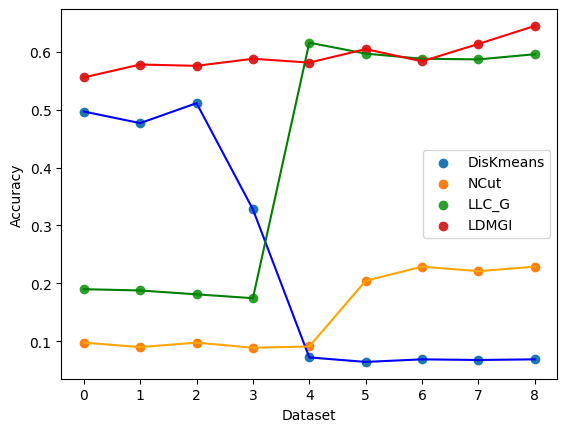

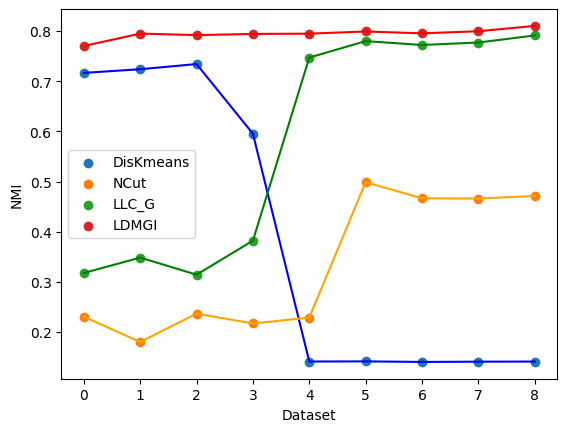

In [52]:
plt.scatter(range(len(nrounds_DisKmeans_accs)), nrounds_DisKmeans_accs, linestyle='-', label='DisKmeans')
plt.plot(range(len(nrounds_DisKmeans_accs)), nrounds_DisKmeans_accs, linestyle='-', color='blue')
plt.scatter(range(len(nrounds_NCut_accs)), nrounds_NCut_accs, linestyle='-', label='NCut')
plt.plot(range(len(nrounds_NCut_accs)), nrounds_NCut_accs, linestyle='-', color='orange')
plt.scatter(range(len(nrounds_LLC_G_accs)), nrounds_LLC_G_accs, linestyle='-', label='LLC_G')
plt.plot(range(len(nrounds_LLC_G_accs)), nrounds_LLC_G_accs, linestyle='-', color='green')
plt.scatter(range(len(nrounds_LDMGI_accs)), nrounds_LDMGI_accs, linestyle='-', label='LDMGI')
plt.plot(range(len(nrounds_LDMGI_accs)), nrounds_LDMGI_accs, linestyle='-', color='red')

plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.scatter(range(len(nrounds_DisKmeans_nmis)), nrounds_DisKmeans_nmis, linestyle='-', label='DisKmeans')
plt.plot(range(len(nrounds_DisKmeans_nmis)), nrounds_DisKmeans_nmis, linestyle='-', color='blue')
plt.scatter(range(len(nrounds_NCut_nmis)), nrounds_NCut_nmis, linestyle='-', label='NCut')
plt.plot(range(len(nrounds_NCut_nmis)), nrounds_NCut_nmis, linestyle='-', color='orange')
plt.scatter(range(len(nrounds_LLC_G_nmis)), nrounds_LLC_G_nmis, linestyle='-', label='LLC_G')
plt.plot(range(len(nrounds_LLC_G_nmis)), nrounds_LLC_G_nmis, linestyle='-', color='green')
plt.scatter(range(len(nrounds_LDMGI_nmis)), nrounds_LDMGI_nmis, linestyle='-', label='LDMGI')
plt.plot(range(len(nrounds_LDMGI_nmis)), nrounds_LDMGI_nmis, linestyle='-', color='red')

plt.xlabel('Dataset')
plt.ylabel('NMI')
plt.legend()
plt.show()

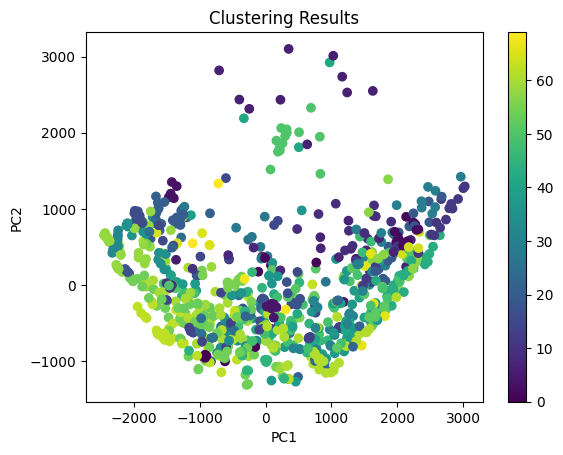

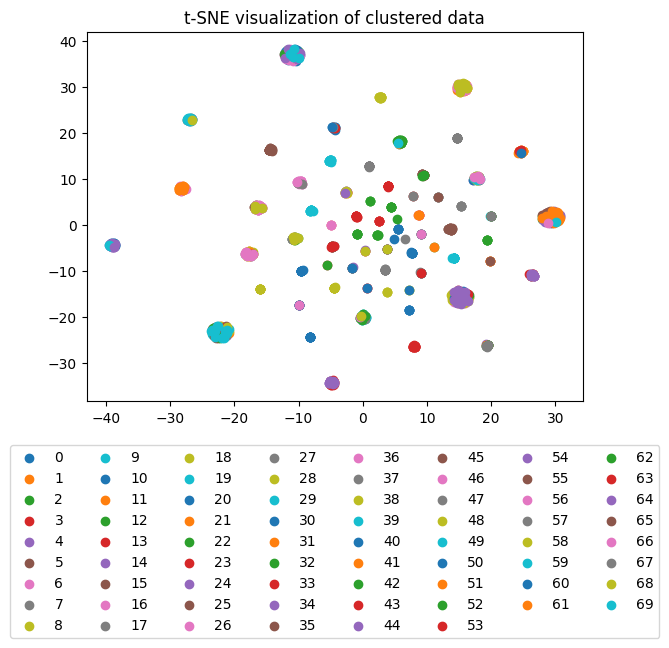

In [53]:
# The intuitive impression of LDMGI clustering results 1 
X = images
Y = LDMGI(X = images,k = 5,c =n_clusters)
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Clustering Results Visualization Plot
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Y.argmax(axis=1))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clustering Results')
plt.colorbar()
plt.show()
# The intuitive impression of LDMGI clustering results 2 
X = images
y = labels

Y = LDMGI(X, k=5, c =n_clusters)

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(Y)

for i in range(n_clusters):
    plt.scatter(X_tsne[y==i, 0], X_tsne[y==i, 1], label=i)
plt.title('t-SNE visualization of clustered data')
plt.legend(ncol=8, bbox_to_anchor=(0.5, -0.1), loc='upper center')
plt.show()

图片数据集维度： (70000, 28, 28)
特征数量： 70000
标签数量： 10


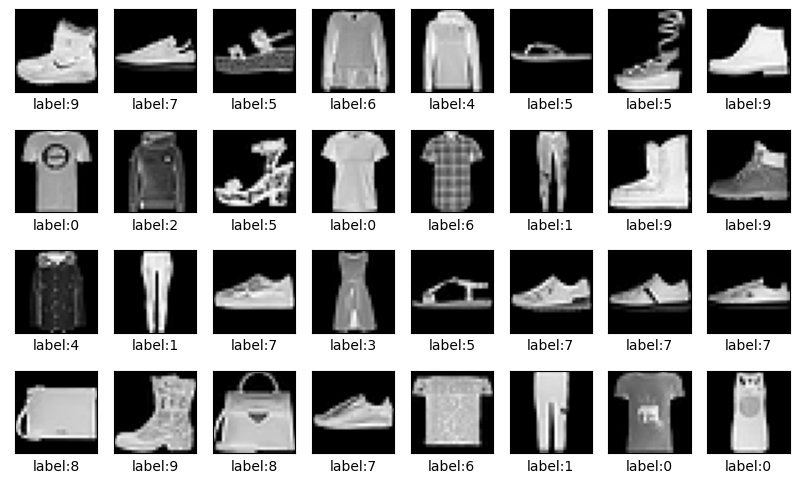

In [76]:
fmnist = fetch_openml(name='Fashion-MNIST')

images = fmnist.data.to_numpy().reshape(-1, 28, 28)  
labels = fmnist.target.to_numpy().astype(int)  

print("图片数据集维度：", images.shape)
print("特征数量：", len(labels))
print("标签数量：",len(np.unique(labels)))


_, axes = plt.subplots(4,8,figsize=(10,6))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(images[i*6],cmap='gray')
    
    ax.set_xlabel(f'label:{labels[i*6]}')
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

LDMGI
max acc: 0.635
max nmi: 0.645604641712652
mean acc: 0.6204999999999999 ± 0.013683932183404022
mean nmi: 0.6327963245333024 ± 0.004269439059783187
KMeans
max acc: 0.625
max nmi: 0.580148501583412
mean acc: 0.585 ± 0.03741657386773941
mean nmi: 0.5763512835993513 ± 0.004650623251534382
DisKmeans
max acc: 0.575
max nmi: 0.575903291709666
mean acc: 0.517 ± 0.03155946767611899
mean nmi: 0.5358292803309533 ± 0.020263283905952802
NCut
max acc: 0.63
max nmi: 0.6137700906245636
mean acc: 0.6224999999999999 ± 0.015041608956491336
mean nmi: 0.6086424084450192 ± 0.008235561587461263
LLC_G
max acc: 0.59
max nmi: 0.6154292795753231
mean acc: 0.5809999999999998 ± 0.02699999999999999
mean nmi: 0.5967805461531966 ± 0.02872757843700312
LLC_L
max acc: 0.565
max nmi: 0.6074822950090963
mean acc: 0.5439999999999999 ± 0.0347706773014274
mean nmi: 0.5717784665007253 ± 0.05109626444343047


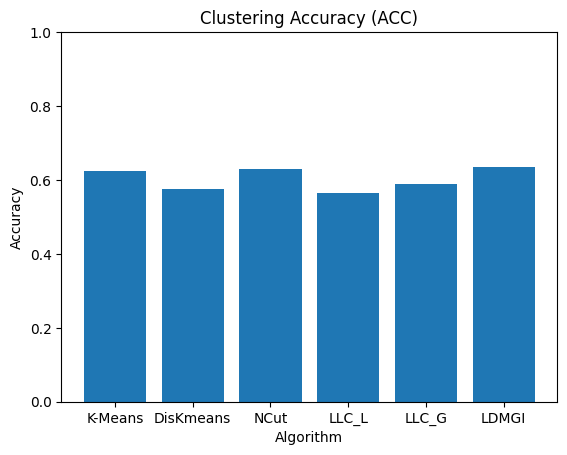

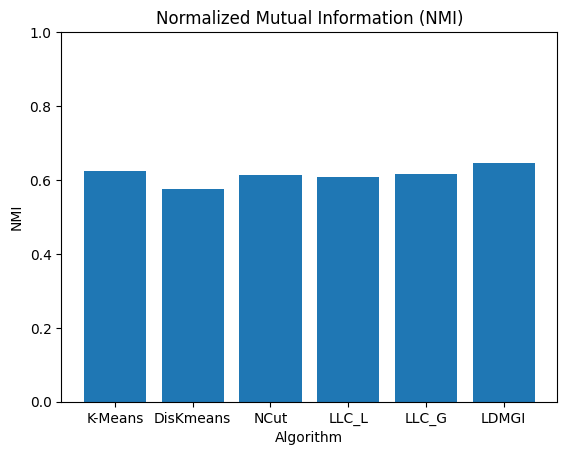

ACC_scores: [0.625, 0.575, 0.63, 0.565, 0.59, 0.635]
NMI_scores: [0.625, 0.575903291709666, 0.6137700906245636, 0.6074822950090963, 0.6154292795753231, 0.645604641712652]


In [77]:
ACC_scores = []
NMI_scores = []

nrounds_KMeans_acc,nrounds_KMeans_acc,nrounds_DisKmeans_accs,nrounds_DisKmeans_nmis,nrounds_NCut_accs,nrounds_NCut_nmis,nrounds_LLC_L_acc,nrounds_LLC_L_nmi,nrounds_LLC_G_accs,nrounds_LLC_G_nmis,nrounds_LDMGI_accs,nrounds_LDMGI_nmis = run_five_algos()

# K-Means Clustering

ACC_scores.append(nrounds_KMeans_acc)
NMI_scores.append(nrounds_KMeans_acc)

# DisKmeans
ACC_scores.append(max(nrounds_DisKmeans_accs))
NMI_scores.append(max(nrounds_DisKmeans_nmis))

# NCut
ACC_scores.append(max(nrounds_NCut_accs))
NMI_scores.append(max(nrounds_NCut_nmis))

# LLC_L

ACC_scores.append(nrounds_LLC_L_acc)
NMI_scores.append(nrounds_LLC_L_nmi)

# LLC_G
ACC_scores.append(max(nrounds_LLC_G_accs))
NMI_scores.append(max(nrounds_LLC_G_nmis))

# LDMGI with K-means
ACC_scores.append(max(nrounds_LDMGI_accs))
NMI_scores.append(max(nrounds_LDMGI_nmis))

plt.bar([ 'K-Means', 'DisKmeans', 'NCut','LLC_L','LLC_G','LDMGI'], ACC_scores)
plt.title('Clustering Accuracy (ACC)')
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.show()


plt.bar([ 'K-Means', 'DisKmeans', 'NCut','LLC_L','LLC_G','LDMGI'], NMI_scores)
plt.title('Normalized Mutual Information (NMI)')
plt.xlabel('Algorithm')
plt.ylabel('NMI')
plt.ylim([0, 1])
plt.show()

print("ACC_scores:",ACC_scores)
print("NMI_scores:",NMI_scores)

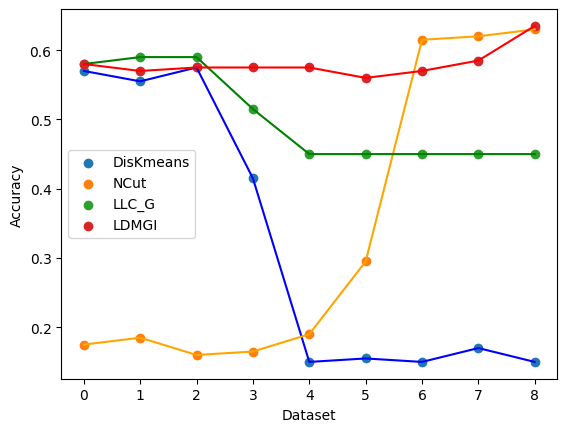

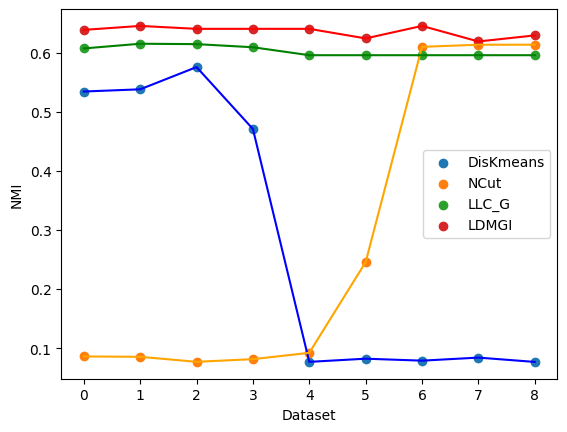

In [78]:
plt.scatter(range(len(nrounds_DisKmeans_accs)), nrounds_DisKmeans_accs, linestyle='-', label='DisKmeans')
plt.plot(range(len(nrounds_DisKmeans_accs)), nrounds_DisKmeans_accs, linestyle='-', color='blue')
plt.scatter(range(len(nrounds_NCut_accs)), nrounds_NCut_accs, linestyle='-', label='NCut')
plt.plot(range(len(nrounds_NCut_accs)), nrounds_NCut_accs, linestyle='-', color='orange')
plt.scatter(range(len(nrounds_LLC_G_accs)), nrounds_LLC_G_accs, linestyle='-', label='LLC_G')
plt.plot(range(len(nrounds_LLC_G_accs)), nrounds_LLC_G_accs, linestyle='-', color='green')
plt.scatter(range(len(nrounds_LDMGI_accs)), nrounds_LDMGI_accs, linestyle='-', label='LDMGI')
plt.plot(range(len(nrounds_LDMGI_accs)), nrounds_LDMGI_accs, linestyle='-', color='red')

plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.scatter(range(len(nrounds_DisKmeans_nmis)), nrounds_DisKmeans_nmis, linestyle='-', label='DisKmeans')
plt.plot(range(len(nrounds_DisKmeans_nmis)), nrounds_DisKmeans_nmis, linestyle='-', color='blue')
plt.scatter(range(len(nrounds_NCut_nmis)), nrounds_NCut_nmis, linestyle='-', label='NCut')
plt.plot(range(len(nrounds_NCut_nmis)), nrounds_NCut_nmis, linestyle='-', color='orange')
plt.scatter(range(len(nrounds_LLC_G_nmis)), nrounds_LLC_G_nmis, linestyle='-', label='LLC_G')
plt.plot(range(len(nrounds_LLC_G_nmis)), nrounds_LLC_G_nmis, linestyle='-', color='green')
plt.scatter(range(len(nrounds_LDMGI_nmis)), nrounds_LDMGI_nmis, linestyle='-', label='LDMGI')
plt.plot(range(len(nrounds_LDMGI_nmis)), nrounds_LDMGI_nmis, linestyle='-', color='red')

plt.xlabel('Dataset')
plt.ylabel('NMI')
plt.legend()
plt.show()

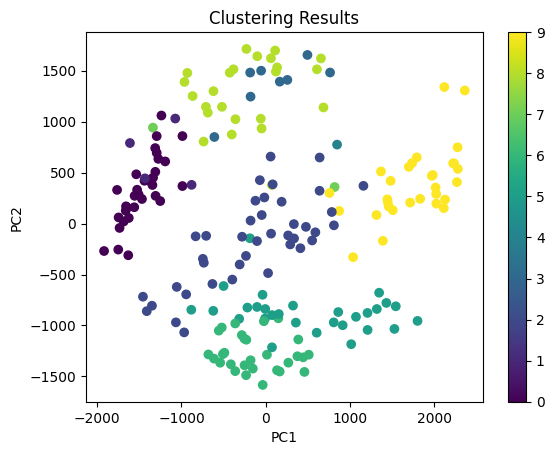

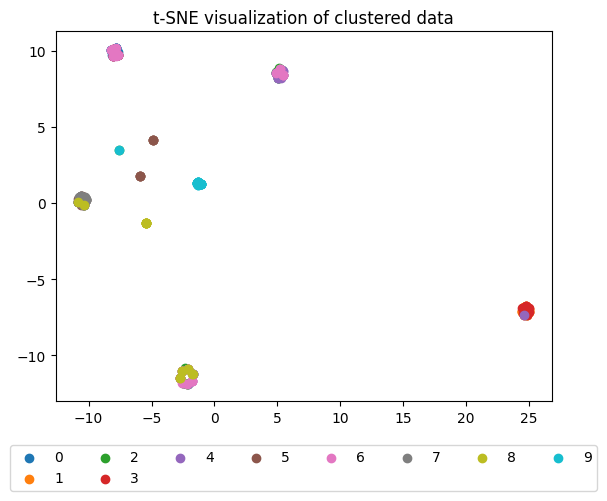

In [79]:
# The intuitive impression of LDMGI clustering results 1 
X = images
Y = LDMGI(X = images,k = 5,c =n_clusters)
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Clustering Results Visualization Plot
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Y.argmax(axis=1))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clustering Results')
plt.colorbar()
plt.show()
# The intuitive impression of LDMGI clustering results 2 
X = images
y = labels

Y = LDMGI(X, k=5, c =n_clusters)

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(Y)

for i in range(n_clusters):
    plt.scatter(X_tsne[y==i, 0], X_tsne[y==i, 1], label=i)
plt.title('t-SNE visualization of clustered data')
plt.legend(ncol=8, bbox_to_anchor=(0.5, -0.1), loc='upper center')
plt.show()

图片数据集维度： (1440, 64, 64)
特征数量： 1440
标签数量： 20


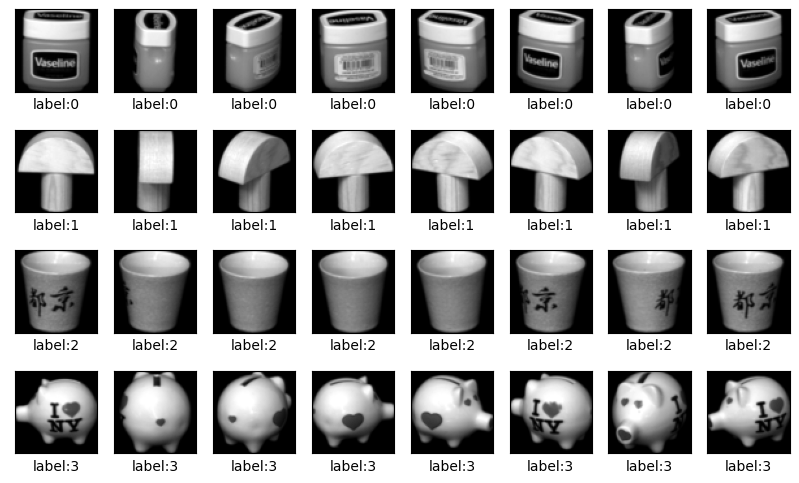

In [80]:
def load_dataset():
    data = []
    all_imgs_path = glob.glob(r'C:\Users\32204\Desktop\COIL-20_dataset\*.png')
    for ip in all_imgs_path:
        data.append(ip)
    labels = []
    for i in range(20):
        labels.extend([i] * 72)
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
    ])
    dataset = []
    for i in range(len(labels)):
        temp_img = Image.open(data[i])
        temp_img = transform(temp_img)
        temp_array = np.array(temp_img)
        dataset.append(temp_array)
    dataset = np.stack(dataset, axis=0) 
    return dataset,labels

images,labels = load_dataset() 
labels = np.array(labels)

print("图片数据集维度：", images.shape)
print("特征数量：", len(labels))
print("标签数量：",len(np.unique(labels)))

_, axes = plt.subplots(4,8,figsize=(10,6))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(images[i*9],cmap='gray')
    
    ax.set_xlabel(f'label:{labels[i*9]}')
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

LDMGI
max acc: 0.76
max nmi: 0.855168347139776
mean acc: 0.7434999999999999 ± 0.03178443015062562
mean nmi: 0.8460410507340189 ± 0.018254592811513915
KMeans
max acc: 0.75
max nmi: 0.8289963210679161
mean acc: 0.725 ± 0.049999999999999996
mean nmi: 0.8149559203668527 ± 0.028080801402126807
DisKmeans
max acc: 0.655
max nmi: 0.7852243151969243
mean acc: 0.639 ± 0.019595917942265444
mean nmi: 0.780872892595644 ± 0.004117936056059227
NCut
max acc: 0.335
max nmi: 0.47473695084812045
mean acc: 0.3275 ± 0.0075000000000000075
mean nmi: 0.4668710218811379 ± 0.01150087091758241
LLC_G
max acc: 0.735
max nmi: 0.8223057763840179
mean acc: 0.7025 ± 0.05046038049797088
mean nmi: 0.8100651477986679 ± 0.013733749723077029
LLC_L
max acc: 0.535
max nmi: 0.6856742076615215
mean acc: 0.4565 ± 0.05472887720390398
mean nmi: 0.6386354889666618 ± 0.04211240528749819


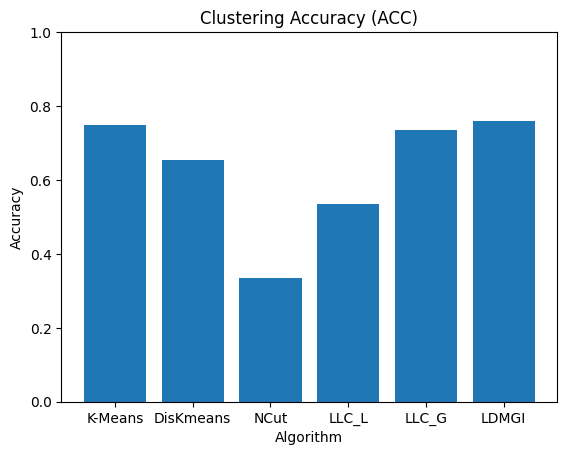

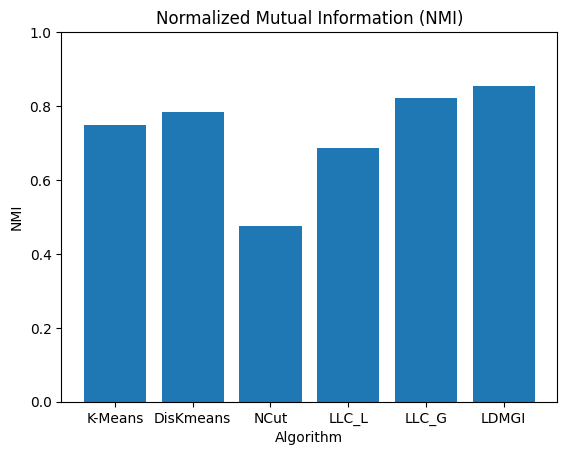

ACC_scores: [0.75, 0.655, 0.335, 0.535, 0.735, 0.76]
NMI_scores: [0.75, 0.7852243151969243, 0.47473695084812045, 0.6856742076615215, 0.8223057763840179, 0.855168347139776]


In [81]:
ACC_scores = []
NMI_scores = []

nrounds_KMeans_acc,nrounds_KMeans_acc,nrounds_DisKmeans_accs,nrounds_DisKmeans_nmis,nrounds_NCut_accs,nrounds_NCut_nmis,nrounds_LLC_L_acc,nrounds_LLC_L_nmi,nrounds_LLC_G_accs,nrounds_LLC_G_nmis,nrounds_LDMGI_accs,nrounds_LDMGI_nmis = run_five_algos()

# K-Means Clustering

ACC_scores.append(nrounds_KMeans_acc)
NMI_scores.append(nrounds_KMeans_acc)

# DisKmeans
ACC_scores.append(max(nrounds_DisKmeans_accs))
NMI_scores.append(max(nrounds_DisKmeans_nmis))

# NCut
ACC_scores.append(max(nrounds_NCut_accs))
NMI_scores.append(max(nrounds_NCut_nmis))

# LLC_L

ACC_scores.append(nrounds_LLC_L_acc)
NMI_scores.append(nrounds_LLC_L_nmi)

# LLC_G
ACC_scores.append(max(nrounds_LLC_G_accs))
NMI_scores.append(max(nrounds_LLC_G_nmis))

# LDMGI with K-means
ACC_scores.append(max(nrounds_LDMGI_accs))
NMI_scores.append(max(nrounds_LDMGI_nmis))

plt.bar([ 'K-Means', 'DisKmeans', 'NCut','LLC_L','LLC_G','LDMGI'], ACC_scores)
plt.title('Clustering Accuracy (ACC)')
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.show()

plt.bar([ 'K-Means', 'DisKmeans', 'NCut','LLC_L','LLC_G','LDMGI'], NMI_scores)
plt.title('Normalized Mutual Information (NMI)')
plt.xlabel('Algorithm')
plt.ylabel('NMI')
plt.ylim([0, 1])
plt.show()

print("ACC_scores:",ACC_scores)
print("NMI_scores:",NMI_scores)

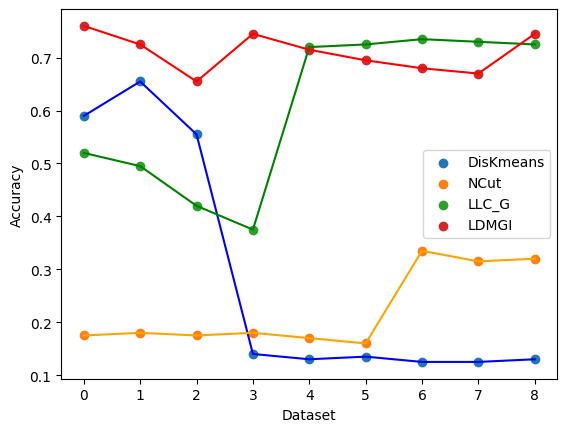

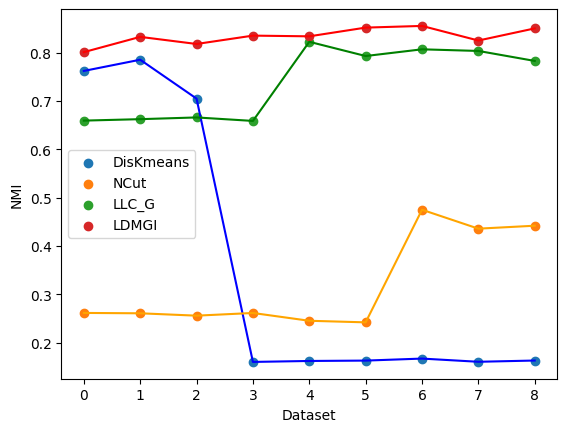

In [82]:
plt.scatter(range(len(nrounds_DisKmeans_accs)), nrounds_DisKmeans_accs, linestyle='-', label='DisKmeans')
plt.plot(range(len(nrounds_DisKmeans_accs)), nrounds_DisKmeans_accs, linestyle='-', color='blue')
plt.scatter(range(len(nrounds_NCut_accs)), nrounds_NCut_accs, linestyle='-', label='NCut')
plt.plot(range(len(nrounds_NCut_accs)), nrounds_NCut_accs, linestyle='-', color='orange')
plt.scatter(range(len(nrounds_LLC_G_accs)), nrounds_LLC_G_accs, linestyle='-', label='LLC_G')
plt.plot(range(len(nrounds_LLC_G_accs)), nrounds_LLC_G_accs, linestyle='-', color='green')
plt.scatter(range(len(nrounds_LDMGI_accs)), nrounds_LDMGI_accs, linestyle='-', label='LDMGI')
plt.plot(range(len(nrounds_LDMGI_accs)), nrounds_LDMGI_accs, linestyle='-', color='red')

plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.scatter(range(len(nrounds_DisKmeans_nmis)), nrounds_DisKmeans_nmis, linestyle='-', label='DisKmeans')
plt.plot(range(len(nrounds_DisKmeans_nmis)), nrounds_DisKmeans_nmis, linestyle='-', color='blue')
plt.scatter(range(len(nrounds_NCut_nmis)), nrounds_NCut_nmis, linestyle='-', label='NCut')
plt.plot(range(len(nrounds_NCut_nmis)), nrounds_NCut_nmis, linestyle='-', color='orange')
plt.scatter(range(len(nrounds_LLC_G_nmis)), nrounds_LLC_G_nmis, linestyle='-', label='LLC_G')
plt.plot(range(len(nrounds_LLC_G_nmis)), nrounds_LLC_G_nmis, linestyle='-', color='green')
plt.scatter(range(len(nrounds_LDMGI_nmis)), nrounds_LDMGI_nmis, linestyle='-', label='LDMGI')
plt.plot(range(len(nrounds_LDMGI_nmis)), nrounds_LDMGI_nmis, linestyle='-', color='red')

plt.xlabel('Dataset')
plt.ylabel('NMI')
plt.legend()
plt.show()

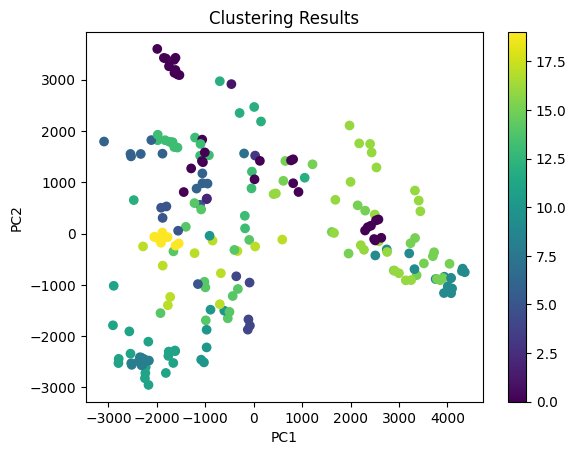

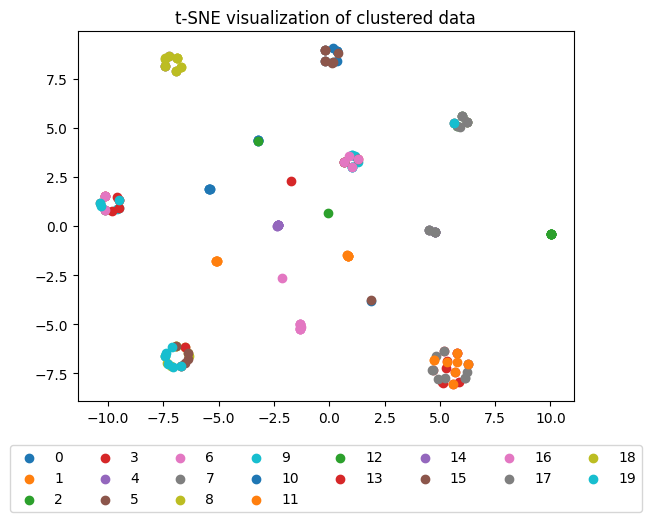

In [83]:
# The intuitive impression of LDMGI clustering results 1 
X = images
Y = LDMGI(X = images,k = 5,c =n_clusters)
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Clustering Results Visualization Plot
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Y.argmax(axis=1))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clustering Results')
plt.colorbar()
plt.show()
# The intuitive impression of LDMGI clustering results 2 
X = images
y = labels

Y = LDMGI(X, k=5, c =n_clusters)

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(Y)

for i in range(n_clusters):
    plt.scatter(X_tsne[y==i, 0], X_tsne[y==i, 1], label=i)
plt.title('t-SNE visualization of clustered data')
plt.legend(ncol=8, bbox_to_anchor=(0.5, -0.1), loc='upper center')
plt.show()

图片数据集维度： (400, 64, 64)
特征数量： 400
标签数量： 40


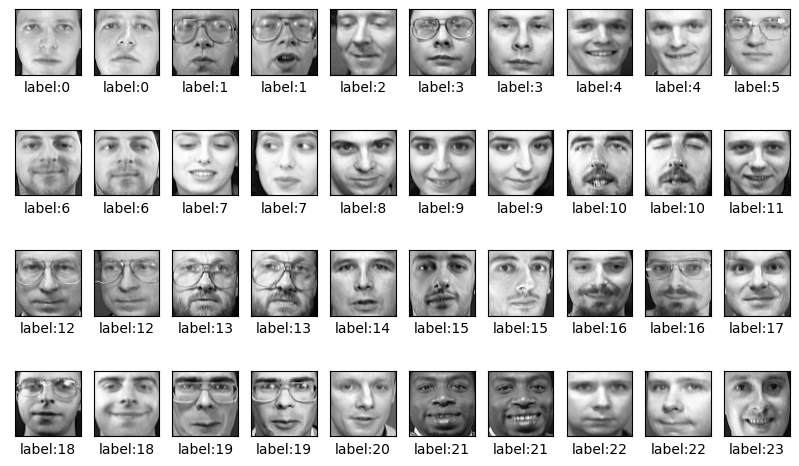

In [210]:
dataset = fetch_olivetti_faces()
images = dataset.images
labels = dataset.target

print("图片数据集维度：", images.shape)
print("特征数量：", len(labels))
print("标签数量：",len(np.unique(labels)))

_, axes = plt.subplots(4,10,figsize=(10,6))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(images[i*6],cmap='gray')
    
    ax.set_xlabel(f'label:{labels[i*6]}')
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

LDMGI
max acc: 0.6485714285714286
max nmi: 0.824254461371476
mean acc: 0.6425714285714286 ± 0.00324509048331444
mean nmi: 0.8216450247220747 ± 0.0019396919303755946
KMeans
max acc: 0.6342857142857142
max nmi: 0.8022335331179493
mean acc: 0.6282857142857143 ± 0.009165151389911638
mean nmi: 0.8022335331179493 ± 0.0
DisKmeans
max acc: 0.5057142857142857
max nmi: 0.7303003917331389
mean acc: 0.5039999999999999 ± 0.0034285714285714032
mean nmi: 0.7280800763151067 ± 0.001453537638544328
NCut
max acc: 0.5514285714285714
max nmi: 0.6836919860581846
mean acc: 0.5402857142857143 ± 0.017164272338143535
mean nmi: 0.6791535657554986 ± 0.0069904798159638355
LLC_G
max acc: 0.6371428571428571
max nmi: 0.8262735188193194
mean acc: 0.6285714285714286 ± 0.006998542122237627
mean nmi: 0.8199366715137015 ± 0.009754070195383269
LLC_L
max acc: 0.5942857142857143
max nmi: 0.8190958794578538
mean acc: 0.5854285714285714 ± 0.014481515311399098
mean nmi: 0.8083351705427253 ± 0.016799846192873745


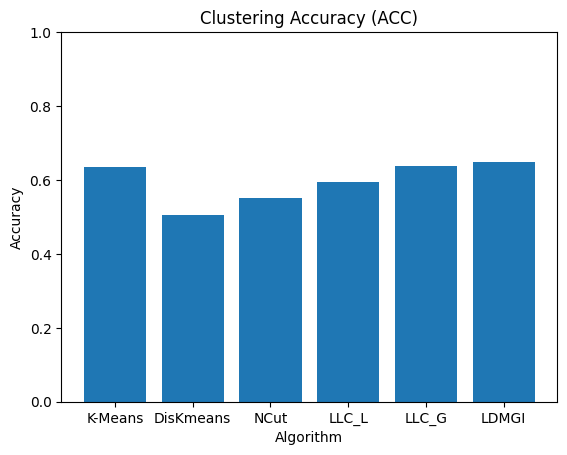

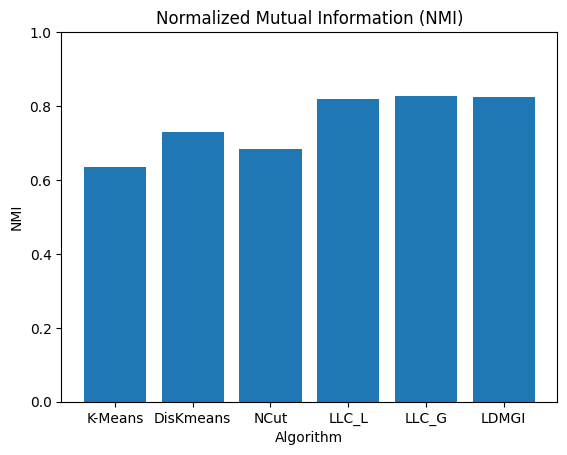

ACC_scores: [0.6342857142857142, 0.5057142857142857, 0.5514285714285714, 0.5942857142857143, 0.6371428571428571, 0.6485714285714286]
NMI_scores: [0.6342857142857142, 0.7303003917331389, 0.6836919860581846, 0.8190958794578538, 0.8262735188193194, 0.824254461371476]


In [211]:
ACC_scores = []
NMI_scores = []

nrounds_KMeans_acc,nrounds_KMeans_acc,nrounds_DisKmeans_accs,nrounds_DisKmeans_nmis,nrounds_NCut_accs,nrounds_NCut_nmis,nrounds_LLC_L_acc,nrounds_LLC_L_nmi,nrounds_LLC_G_accs,nrounds_LLC_G_nmis,nrounds_LDMGI_accs,nrounds_LDMGI_nmis = run_five_algos()

# K-Means Clustering

ACC_scores.append(nrounds_KMeans_acc)
NMI_scores.append(nrounds_KMeans_acc)

# DisKmeans
ACC_scores.append(max(nrounds_DisKmeans_accs))
NMI_scores.append(max(nrounds_DisKmeans_nmis))

# NCut
ACC_scores.append(max(nrounds_NCut_accs))
NMI_scores.append(max(nrounds_NCut_nmis))

# LLC_L

ACC_scores.append(nrounds_LLC_L_acc)
NMI_scores.append(nrounds_LLC_L_nmi)

# LLC_G
ACC_scores.append(max(nrounds_LLC_G_accs))
NMI_scores.append(max(nrounds_LLC_G_nmis))

# LDMGI with K-means
ACC_scores.append(max(nrounds_LDMGI_accs))
NMI_scores.append(max(nrounds_LDMGI_nmis))

plt.bar([ 'K-Means', 'DisKmeans', 'NCut','LLC_L','LLC_G','LDMGI'], ACC_scores)
plt.title('Clustering Accuracy (ACC)')
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.show()

plt.bar([ 'K-Means', 'DisKmeans', 'NCut','LLC_L','LLC_G','LDMGI'], NMI_scores)
plt.title('Normalized Mutual Information (NMI)')
plt.xlabel('Algorithm')
plt.ylabel('NMI')
plt.ylim([0, 1])
plt.show()

print("ACC_scores:",ACC_scores)
print("NMI_scores:",NMI_scores)

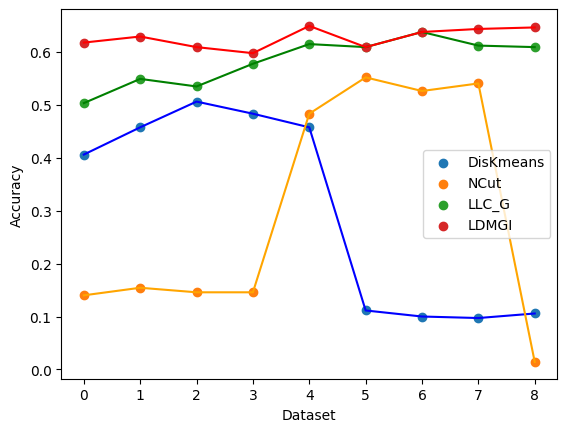

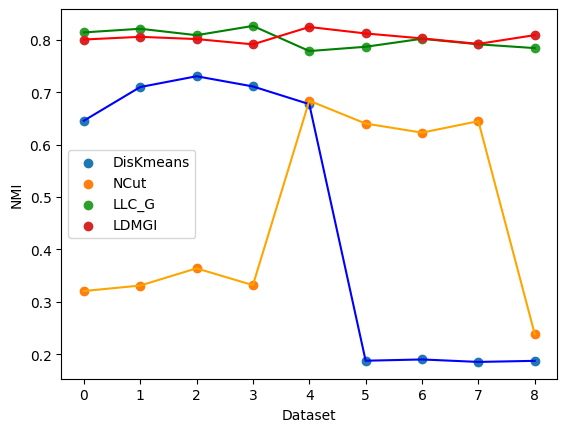

In [212]:
plt.scatter(range(len(nrounds_DisKmeans_accs)), nrounds_DisKmeans_accs, linestyle='-', label='DisKmeans')
plt.plot(range(len(nrounds_DisKmeans_accs)), nrounds_DisKmeans_accs, linestyle='-', color='blue')
plt.scatter(range(len(nrounds_NCut_accs)), nrounds_NCut_accs, linestyle='-', label='NCut')
plt.plot(range(len(nrounds_NCut_accs)), nrounds_NCut_accs, linestyle='-', color='orange')
plt.scatter(range(len(nrounds_LLC_G_accs)), nrounds_LLC_G_accs, linestyle='-', label='LLC_G')
plt.plot(range(len(nrounds_LLC_G_accs)), nrounds_LLC_G_accs, linestyle='-', color='green')
plt.scatter(range(len(nrounds_LDMGI_accs)), nrounds_LDMGI_accs, linestyle='-', label='LDMGI')
plt.plot(range(len(nrounds_LDMGI_accs)), nrounds_LDMGI_accs, linestyle='-', color='red')

plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.scatter(range(len(nrounds_DisKmeans_nmis)), nrounds_DisKmeans_nmis, linestyle='-', label='DisKmeans')
plt.plot(range(len(nrounds_DisKmeans_nmis)), nrounds_DisKmeans_nmis, linestyle='-', color='blue')
plt.scatter(range(len(nrounds_NCut_nmis)), nrounds_NCut_nmis, linestyle='-', label='NCut')
plt.plot(range(len(nrounds_NCut_nmis)), nrounds_NCut_nmis, linestyle='-', color='orange')
plt.scatter(range(len(nrounds_LLC_G_nmis)), nrounds_LLC_G_nmis, linestyle='-', label='LLC_G')
plt.plot(range(len(nrounds_LLC_G_nmis)), nrounds_LLC_G_nmis, linestyle='-', color='green')
plt.scatter(range(len(nrounds_LDMGI_nmis)), nrounds_LDMGI_nmis, linestyle='-', label='LDMGI')
plt.plot(range(len(nrounds_LDMGI_nmis)), nrounds_LDMGI_nmis, linestyle='-', color='red')

plt.xlabel('Dataset')
plt.ylabel('NMI')
plt.legend()
plt.show()

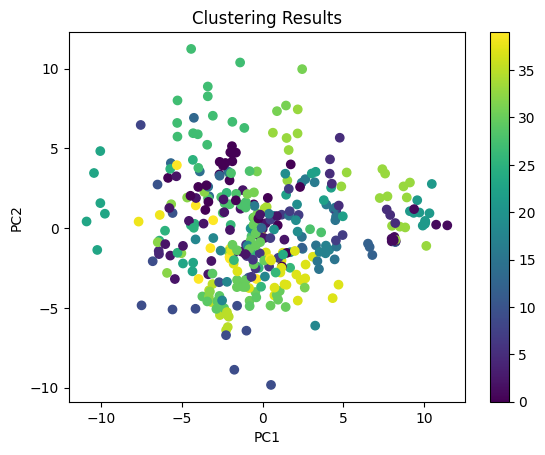

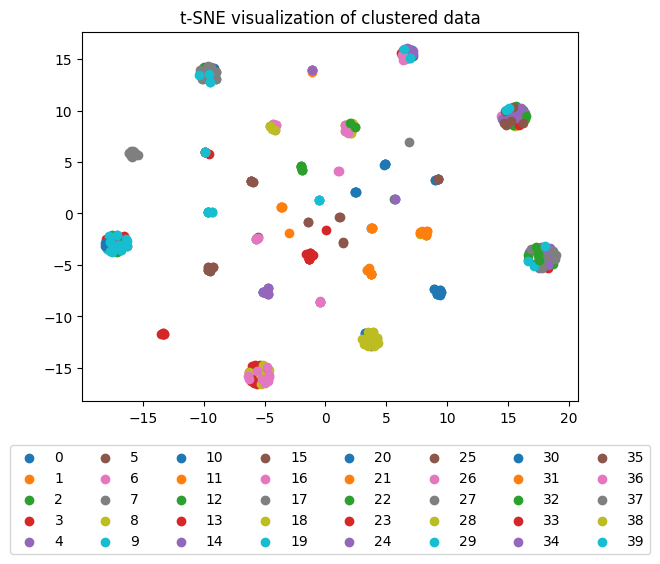

In [213]:
# The intuitive impression of LDMGI clustering results 1 
X = images
Y = LDMGI(X = images,k = 5,c =n_clusters)
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Clustering Results Visualization Plot
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Y.argmax(axis=1))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clustering Results')
plt.colorbar()
plt.show()
# The intuitive impression of LDMGI clustering results 2 
X = images
y = labels

Y = LDMGI(X, k=5, c =n_clusters)

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(Y)

for i in range(n_clusters):
    plt.scatter(X_tsne[y==i, 0], X_tsne[y==i, 1], label=i)
plt.title('t-SNE visualization of clustered data')
plt.legend(ncol=8, bbox_to_anchor=(0.5, -0.1), loc='upper center')
plt.show()